# Libraries

In [1]:
import  pandas            as pd
import  numpy             as np
import  plotly.express    as px
import  matplotlib.pyplot as plt
import  plotly.graph_objs as go
import  plotly.io         as pio
from    plotly.subplots         import make_subplots
from    sklearn.model_selection import train_test_split
from    sklearn.impute          import SimpleImputer
from    imblearn.over_sampling  import SMOTE
from    sklearn.preprocessing   import StandardScaler
from    sklearn.ensemble        import RandomForestClassifier
from    xgboost                 import XGBClassifier
from    sklearn.neural_network  import MLPClassifier
from    sklearn.ensemble        import AdaBoostClassifier
from    sklearn.model_selection import RandomizedSearchCV
from    sklearn.model_selection import cross_validate
from    sklearn.metrics         import make_scorer
from    sklearn.metrics         import accuracy_score
from    sklearn.metrics         import confusion_matrix
from    sklearn.metrics         import precision_score
from    sklearn.metrics         import recall_score
from    sklearn.metrics         import f1_score
from    sklearn.metrics         import roc_auc_score
from    sklearn.metrics         import ConfusionMatrixDisplay
from    sklearn.metrics         import RocCurveDisplay

In [2]:
RANDOM_SEED = np.random.seed(31)

In [3]:
cd ..\

c:\Users\victo\Downloads\00. Estudo Data Science\aps_failure_truck_prediction


c:\Users\victo\Downloads\00. Estudo Data Science\aps_failure_truck_prediction\venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Train

In [4]:
df_train = pd.read_csv('data\\original\\air_system_previous_years.csv',
                       encoding='utf-8',
                       na_values=['na']
                      )
df_train.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,neg,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,neg,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


In [5]:
df_isna = df_train.drop(columns='class')
df_isna = df_isna.isna().sum().sort_values(ascending=False).to_frame('total_nan')
df_isna['total_data'] = df_train.shape[0]
df_isna['pct_nan'] = (df_isna['total_nan'] / df_isna['total_data'] * 100).round(2)
df_isna

,total_nan,total_data,pct_nan
br_000,49264,60000,82.11
bq_000,48722,60000,81.20
bp_000,47740,60000,79.57
bo_000,46333,60000,77.22
ab_000,46329,60000,77.22
...,...,...,...
ck_000,338,60000,0.56
ci_000,338,60000,0.56
cj_000,338,60000,0.56
bt_000,167,60000,0.28


In [6]:
fig = px.bar(df_isna,
             x=df_isna.index,
             y='pct_nan',
             text_auto='pct_nan'
             )
fig.update_layout(height=400,
                  width=800,
                  showlegend=True,
                  margin=dict(l=10, r=10, b=10, t=10),
                  yaxis=dict(title='Total NaN (%)', dtick=10),
                  xaxis=dict(title='Feature')
                  )
fig.show()

In [7]:
# Remove features with over 50% of NaN data
features_low_nan = df_isna[df_isna['pct_nan'] <= 50].index.to_list()

In [8]:
df_features = df_train[features_low_nan].astype(float)

# Change class object to int dummies
map_class = {'neg': 0, 'pos': 1}
df_target = df_train['class'].map(map_class).to_frame('class').astype(int)

In [9]:
df_count_class = df_target.value_counts().to_frame()
df_count_class

,count
class,
0,59000
1,1000


In [10]:
fig = px.bar(df_count_class,
             x=df_count_class.index.get_level_values('class'),
             y='count',
             text_auto='count'
             )
fig.update_layout(height=400,
                  width=800,
                  showlegend=True,
                  margin=dict(l=10, r=10, b=10, t=10),
                  yaxis=dict(title='Total'),
                  xaxis=dict(title='Class',
                             tickvals=['neg', 'pos'],
                             ticktext=['Negative', 'Positive'])
                  )
fig.show()

In [11]:
# Calculate events proportion
total     = df_target.shape[0]
non_event = df_target[df_target['class'] == 0].shape[0]
event     = df_target[df_target['class'] == 1].shape[0]

non_event_percent = round(non_event / total * 100, 2)
event_percent     = round(event / total * 100, 2)

df_percent_events = pd.DataFrame([non_event_percent, event_percent],
                                 columns=['percent'],
                                 index=['non_event', 'event']
                                 )
df_percent_events

,percent
non_event,98.33
event,1.67


In [12]:
fig = px.bar(df_percent_events,
             x=df_percent_events.index,
             y='percent',
             text_auto=True
             )
fig.update_layout(height=400,
                  width=800,
                  showlegend=True,
                  margin=dict(l=10, r=10, b=10, t=10),
                  yaxis = dict(title='Total (%)'),
                  xaxis = dict(title='Class',
                               tickvals=['non_event', 'event'],
                               ticktext=['Negative', 'Positive'])
                  )
fig.show()

In [13]:
# Identify features with zero variance
features_zero_variance = [col for col in df_features if df_features[col].std() == 0]
print(features_zero_variance)
df_features.drop(columns=features_zero_variance, inplace=True)

['cd_000']


## Split train and validation

In [14]:
X_train, X_val, y_train, y_val = train_test_split(df_features, df_target, test_size=0.3, random_state=RANDOM_SEED)

## Input data on NaN

In [15]:
# Use the median to replace NaN values
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer.fit(X_train)

# # Save the imputer to a file
# with open('train_artifacts\\simple_imputer.pkl', 'wb') as file:
#     pickle.dump(imputer, file)

# # Load the imputer from the file
# with open('train_artifacts\\simple_imputer.pkl', 'rb') as file:
#     imputer = pickle.load(file)

# Fill NaN on train
X_train_filled_nan = imputer.transform(X_train)
X_train_filled_nan = pd.DataFrame(X_train_filled_nan, columns=X_train.columns)
print(X_train_filled_nan.isna().sum().sum())

# Fill NaN on validation
X_val_filled_nan = imputer.transform(X_val)
X_val_filled_nan = pd.DataFrame(X_val_filled_nan, columns=X_train.columns)
print(X_val_filled_nan.isna().sum().sum())

0
0


In [16]:
df_val = X_val_filled_nan.join(y_val)
df_val.head()

,bl_000,bk_000,cg_000,ch_000,cf_000,co_000,ad_000,cx_000,cy_000,cz_000,...,ao_000,bj_000,bi_000,by_000,ck_000,ci_000,cj_000,bt_000,aa_000,class
0,223120.0,210550.0,24.0,0.0,2.0,20.0,22.0,8894.0,0.0,56.0,...,194688.0,17962.0,21046.0,398.0,38068.80,31439.04,97958.40,448.53,448.0,0.0
1,149160.0,151280.0,46.0,0.0,2.0,8.0,128.0,44599.0,0.0,205.0,...,25927250.0,2254536.0,1626396.0,236927.0,3757785.60,27214602.24,615681.60,306241.15,306242.0,NaN
2,223120.0,262700.0,152.0,0.0,0.0,30.0,190.0,91508.0,0.0,6496.0,...,1323854.0,268590.0,98804.0,3400.0,575400.00,1035457.92,45625.92,11485.04,11486.0,NaN
3,223120.0,210550.0,18.0,0.0,0.0,0.0,18.0,276.0,0.0,18.0,...,83204.0,12238.0,41222.0,201.0,52356.48,33396.48,0.00,450.48,450.0,NaN
4,481020.0,407440.0,46.0,0.0,2.0,8.0,128.0,44599.0,0.0,205.0,...,23113102.0,8432244.0,3234330.0,103896.0,15401701.44,23994068.16,0.00,175338.11,175338.0,NaN


## Balance data

In [17]:
# Balance train data minority class
oversample = SMOTE(sampling_strategy='minority', random_state=RANDOM_SEED)
oversample.fit(X_train_filled_nan, y_train)

# # Save the oversample to a file
# with open('train_artifacts\\oversample.pkl', 'wb') as file:
#     pickle.dump(oversample, file)

# # Load the oversample from the file
# with open('train_artifacts\\oversample.pkl', 'rb') as file:
#     oversample = pickle.load(file)

# Data balanced
X_train_balanced, y_train_balanced = oversample.fit_resample(X_train_filled_nan, y_train)
# y train form dataframe to series
y_train_balanced = y_train_balanced['class']

In [18]:
df_train_balanced = X_train_balanced.join(y_train_balanced)
df_train_balanced.head()

,bl_000,bk_000,cg_000,ch_000,cf_000,co_000,ad_000,cx_000,cy_000,cz_000,...,ao_000,bj_000,bi_000,by_000,ck_000,ci_000,cj_000,bt_000,aa_000,class
0,223120.0,210550.0,18.0,0.0,0.0,2.0,72.0,28824.0,0.0,42.0,...,93134.0,11718.0,22412.0,332.0,24934.08,85346.88,0.0,1560.87,1560.0,0
1,182000.0,147000.0,46.0,0.0,2.0,8.0,128.0,44599.0,0.0,205.0,...,1989590.0,184192.0,166962.0,13168.0,237656.64,2263753.92,0.0,39676.28,39676.0,0
2,269700.0,321880.0,304.0,0.0,0.0,484.0,1738.0,95572.0,0.0,36342.0,...,9533838.0,924640.0,2146080.0,74086.0,1666955.52,9946325.76,0.0,164987.86,164988.0,0
3,234600.0,231060.0,46.0,0.0,2.0,8.0,128.0,956014.0,4.0,868.0,...,22910020.0,2113040.0,3986672.0,65953.0,9266841.60,16313824.32,0.0,241465.38,241466.0,0
4,215980.0,185540.0,70.0,0.0,2.0,392.0,152.0,6830.0,0.0,1592.0,...,1900564.0,181094.0,263756.0,18238.0,251109.12,2244048.00,0.0,41802.60,41802.0,0


In [19]:
# Calculate train events proportion
size_train_balanced      = df_train_balanced.shape[0]
non_event_train_balanced = df_train_balanced[df_train_balanced['class'] == 0].shape[0]
event_Train_balanced     = df_train_balanced[df_train_balanced['class'] == 1].shape[0]

non_event_train_balanced_percent = round(non_event_train_balanced / size_train_balanced * 100, 2)
event_train_balanced_percent     = round(event_Train_balanced / size_train_balanced * 100, 2)

non_event_train_balanced_percent, event_train_balanced_percent

(50.0, 50.0)

In [20]:
# Calculate validation events proportion
size_val      = df_val.shape[0]
non_event_val = df_val[df_val['class'] == 0].shape[0]
event_val     = df_val[df_val['class'] == 1].shape[0]

non_event_val_percent = round(non_event_val / size_val * 100, 2)
event_val_percent     = round(event_val / size_val * 100, 2)

non_event_val_percent, event_val_percent

(29.58, 0.56)

## Correlations

In [21]:
# df_train_corr = df_train_balanced.corr().round(2)

# fig = go.Figure()
# fig.add_trace(
#     go.Heatmap(
#         x=df_train_corr.columns,
#         y=df_train_corr.index,
#         z=np.array(df_train_corr),
#         text=df_train_corr.values,
#         texttemplate='%{text:.4f}',
#         colorscale='viridis'))

# fig.update_layout(
#     height=2000,
#     width=2000,
#     yaxis=dict(autorange='reversed'))

# html_file ='temp_plot.html'
# pio.write_html(fig, file=html_file, auto_open=True)

Can you present to me the main factors that point to a possible failure in this system?

# Functions

In [133]:
def calculate_metrics_standard_cutoff(y_true, y_predict):
    no_defect_cost  = 10
    preventive_cost = 25
    corrective_cost = 500
    
    accuracy       = accuracy_score(y_true, y_predict)
    precision      = precision_score(y_true, y_predict, zero_division=0)
    recall         = recall_score(y_true, y_predict, zero_division=0)
    f1score        = f1_score(y_true, y_predict, zero_division=0)
    auc_value      = roc_auc_score(y_true, y_predict)
    tn, fp, fn, tp = confusion_matrix(y_true, y_predict).ravel()
    specificity    = tn / (tn + fp)

    false_positive_rate       = fp / (fp + tn) * 100
    false_negative_rate       = fn / (fn + tp) * 100
    false_classification_rate = (fp + fn) / y_predict.shape[0] * 100

    no_defect_maintenance_cost  = fp * no_defect_cost
    preventive_maintenance_cost = tp * preventive_cost
    corrective_maintenance_cost = fn * corrective_cost
    total_maintenance_cost      = no_defect_maintenance_cost \
                                     + preventive_maintenance_cost \
                                     + corrective_maintenance_cost
    
    metrics = []
    metrics.append([accuracy,
                    precision,
                    recall,
                    f1score,
                    auc_value,
                    specificity,
                    tn, fp, fn, tp,
                    false_positive_rate,
                    false_negative_rate,
                    false_classification_rate,
                    no_defect_maintenance_cost,
                    preventive_maintenance_cost,
                    corrective_maintenance_cost,
                    total_maintenance_cost]  
                  )
    print(f'Accuracy:        {accuracy:.2f}')
    print(f'Precision:       {precision:.2f}')
    print(f'Recall:          {recall:.2f}')
    print(f'F1-score:        {f1score:.2f}')
    print(f'Specificity:     {specificity:.2f}')
    print(f'AUC:             {auc_value:.2f}\n')
    print(f'TN:              {tn:.2f}')
    print(f'TP:              {tp:.2f}')
    print(f'FN:              {fn:.2f}')
    print(f'FP:              {fp:.2f}\n')
    print(f'FP rate:         {false_positive_rate:.2f}%')
    print(f'FN rate:         {false_negative_rate:.2f}%')
    print(f'False clf rate:  {false_classification_rate:.2f}%\n')
    print(f'No defect cost:  {no_defect_maintenance_cost:.2f}')
    print(f'Predictive cost: {preventive_maintenance_cost:.2f}')
    print(f'Corrective cost: {corrective_maintenance_cost:.2f}')
    print(f'Total cost:      {total_maintenance_cost:.2f}\n')

    cm = confusion_matrix(y_true, y_predict)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.show()

    RocCurveDisplay.from_predictions(y_true, y_predict).plot

    return metrics

In [134]:
def calculate_metrics_range_cutoff(dataframe_predict_proba, y_true):
    no_defect_cost  = 10
    preventive_cost = 25
    corrective_cost = 500
    results = []
    for cutoff in np.arange(0.05, 0.99, 0.05):
        y_predict      = np.where(dataframe_predict_proba['proba_event'] > cutoff, 1, 0)
        accuracy       = accuracy_score(y_true, y_predict)
        precision      = precision_score(y_true, y_predict, zero_division=0)
        recall         = recall_score(y_true, y_predict, zero_division=0)
        f1score        = f1_score(y_true, y_predict, zero_division=0)
        auc_value      = roc_auc_score(y_true, y_predict)
        tn, fp, fn, tp = confusion_matrix(y_true, y_predict).ravel()
        specificity    = tn / (tn + fp)

        false_positive_rate       = fp / (fp + tn) * 100
        false_negative_rate       = fn / (fn + tp) * 100
        false_classification_rate = (fp + fn) / y_predict.shape[0] * 100

        no_defect_maintenance_cost  = fp * no_defect_cost
        preventive_maintenance_cost = tp * preventive_cost
        corrective_maintenance_cost = fn * corrective_cost
        total_maintenance_cost      = no_defect_maintenance_cost \
                                       + preventive_maintenance_cost \
                                        + corrective_maintenance_cost
                                
        results.append([cutoff, accuracy, precision,
                        recall, f1score,
                        auc_value, tn, fp, fn, tp,
                        specificity, false_positive_rate,
                        false_negative_rate, false_classification_rate,
                        no_defect_maintenance_cost,
                        preventive_maintenance_cost,
                        corrective_maintenance_cost,
                        total_maintenance_cost]
                    )
        
        df_metrics = pd.DataFrame(results,
                                  columns=['cutoff', 'accuracy', 'precision',
                                           'recall', 'f1score' , 'auc_value',
                                           'tn', 'fp', 'fn', 'tp',
                                           'specificity', 'false_positive_rate',
                                           'false_negative_rate', 'false_classification_rate',
                                           'no_defect_maintenance_cost',
                                           'preventive_maintenance_cost',
                                           'corrective_maintenance_cost',
                                           'total_maintenance_cost']
                                 )
        
    return df_metrics

In [135]:
def plot_metrics(dataframe_proba):
    min_total_cost = dataframe_proba['total_maintenance_cost'].min()
    best_cutoff    = dataframe_proba.loc[dataframe_proba['total_maintenance_cost'] \
                                         == min_total_cost]['cutoff'].values[0]
    fig = make_subplots(rows=3, cols=1,
                        vertical_spacing=0.08,
                        horizontal_spacing=0.06,
                        shared_xaxes=False,
                        subplot_titles=['Rates', 'Metrics', 'Costs']
                        )

    fig.add_trace(go.Scatter(
        x=dataframe_proba['cutoff'],
        y=dataframe_proba['false_negative_rate'],
        name='FN rate',
        mode='lines',
        line=dict(color='#eb3040')
        ),
        row=1, col=1
        )

    fig.add_trace(go.Scatter(
        x=dataframe_proba['cutoff'],
        y=dataframe_proba['false_positive_rate'],
        name='FP rate',
        mode='lines',
        line=dict(color='#eb6949')
        ),
        row=1, col=1
        )
        

    fig.add_trace(go.Scatter(
        x=dataframe_proba['cutoff'],
        y=dataframe_proba['false_classification_rate'],
        name='False classification rate',
        mode='lines',
        line=dict(color='#eb8d27')
        ),
        row=1, col=1
        )

    # ***********************************************
    fig.add_trace(go.Scatter(
        x=dataframe_proba['cutoff'],
        y=dataframe_proba['accuracy'],
        name='Accuracy',
        mode='lines',
        line=dict(color='#85ab71')
        ),
        row=2, col=1
        )

    fig.add_trace(go.Scatter(
        x=dataframe_proba['cutoff'],
        y=dataframe_proba['precision'],
        name='Precision',
        mode='lines',
        line=dict(color='#5e8d6f')
        ),
        row=2, col=1
        )

    fig.add_trace(go.Scatter(
        x=dataframe_proba['cutoff'],
        y=dataframe_proba['recall'],
        name='Recall',
        mode='lines',
        line=dict(color='#58b69e')
        ),
        row=2, col=1
        )

    fig.add_trace(go.Scatter(
        x=dataframe_proba['cutoff'],
        y=dataframe_proba['f1score'],
        name='F1-score',
        mode='lines',
        line=dict(color='#c87499')
        ),
        row=2, col=1
        )

    fig.add_trace(go.Scatter(
        x=dataframe_proba['cutoff'],
        y=dataframe_proba['specificity'],
        name='Specificity',
        mode='lines',
        line=dict(color='#cb4d8e')
        ),
        row=2, col=1
        )

    fig.add_trace(go.Scatter(
        x=dataframe_proba['cutoff'],
        y=dataframe_proba['auc_value'],
        name='AUC',
        mode='lines',
        line=dict(color='#988921')
        ),
        row=2, col=1
        )

    # ***********************************************
    fig.add_trace(go.Scatter(
        x=dataframe_proba['cutoff'],
        y=dataframe_proba['no_defect_maintenance_cost'],
        name='No defect maintenance cost',
        mode='lines',
        line=dict(color='green')
        ),
        row=3, col=1
        )
    
    fig.add_trace(go.Scatter(
        x=dataframe_proba['cutoff'],
        y=dataframe_proba['preventive_maintenance_cost'],
        name='Preventive maintenance cost',
        mode='lines',
        line=dict(color='purple')
        ),
        row=3, col=1
        )
    
    fig.add_trace(go.Scatter(
        x=dataframe_proba['cutoff'],
        y=dataframe_proba['corrective_maintenance_cost'],
        name='Corrective maintenance cost',
        mode='lines',
        line=dict(color='red')
        ),
        row=3, col=1
        )
    
    fig.add_trace(go.Scatter(
        x=dataframe_proba['cutoff'],
        y=dataframe_proba['total_maintenance_cost'],
        name='Total maintenance cost',
        mode='lines',
        line=dict(color='blue')
        ),
        row=3, col=1
        )
    
    fig.add_vline(x=best_cutoff,
                  line_dash='dash',
                  label=dict(text=f'Best cutoff {best_cutoff:.2f} \
                             <br>Lower total cost',
                             xanchor='left',
                             yanchor='top')
                  )

    fig.update_layout(height=1200,
                      width=1000,
                      showlegend=True,
                      margin=dict(l=10, r=10, b=10, t=30, pad=0),
                      xaxis1=dict(title='Cutoff', dtick=0.05, range=(0, 1)),
                      xaxis2=dict(title='Cutoff', dtick=0.05, range=(0, 1)),
                      xaxis3=dict(title='Cutoff', dtick=0.05, range=(0, 1)),
                      yaxis1=dict(title='%'),
                      # yaxis2=dict(title='%'),
                      yaxis3=dict(title='US$'),
                      )

    fig.show()

In [25]:
def plot_cross_validation_score(cv_results, score):
    plot_fig, plot_ax = plt.subplots(figsize=(8, 4))
    plot_ax.plot(cv_results[f'train_{score}'],
                 marker='o',
                 linestyle='-',
                 color='blue',
                 label='Train'
                )
    plot_ax.plot(cv_results[f'test_{score}'],
                 marker='o',
                 linestyle='-',
                 color='red',
                 label='Validation'
                )
    plot_ax.set_xlabel('Iteration')
    plot_ax.set_xticks(range(1, len(cv_results[f'train_{score}'])))
    plot_ax.set_ylabel('Score')
    plot_ax.set_title(f'Cross-validation {score} score')
    plot_ax.legend()
    plot_ax.grid(True)

In [26]:
def calculate_feature_importance(model):
    # Calculate feature importance (Gini)
    feat_importance    = model.feature_importances_
    df_feat_importance = pd.DataFrame({'feature'   : model.feature_names_in_,
                                       'importance': feat_importance}
                                      ).sort_values('importance', ascending=True)

    plt.figure(figsize=(8, 4))
    plt.boxplot(x=df_feat_importance['importance'], vert=False)
    plt.xlabel('Importance')
    plt.title('Feature importance distribution')

    df_feat_importance_no_zero = df_feat_importance[df_feat_importance['importance'] > 0]
    plt.figure(figsize=(8, 10))
    plt.barh(df_feat_importance_no_zero['feature'], df_feat_importance_no_zero['importance'])
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title(f'{df_feat_importance_no_zero.shape[0]} importance greater than 0')

    return df_feat_importance_no_zero

# Model

## Random forest

In [27]:
parameters_rf_clf = {
    "model_parameters": {
        "n_estimators": [5, 100],
        "criterion": ["gini"],
        "max_depth": [2, 13],
        "min_samples_split": [0.2, 1],
        "min_samples_leaf": [1, 7]
    },
    "cross_validation": {
        "n_iterations": 5,
        "folders": 5,
        "scores": [
            "recall",
            "f1_macro",
            "roc_auc",
            "precision_macro"
        ]
    },
    "maintenance_cost": {
        "no_defect_cost": 10,
        "preventive_cost": 25,
        "corrective_cost": 500
    },
    "target": "class",
    "cutoff": 0.3,
    "model_name": "rand_forest",
    "predict_method": "predict_proba"
}

In [28]:
def create_hyper_parameters_rf_clf(parameters: dict):
    range_n_estimators = np.arange(start=round(parameters.get('model_parameters')['n_estimators'][0], 2),
                                   stop=round(parameters.get('model_parameters')['n_estimators'][-1], 2),
                                   step=5
                                   )
    range_max_depth = np.arange(start=round(parameters.get('model_parameters')['max_depth'][0], 2),
                                stop=round(parameters.get('model_parameters')['max_depth'][-1], 2),
                                step=2
                                )
    range_min_samples_split = np.arange(start=round(parameters.get('model_parameters')['min_samples_split'][0], 2),
                                        stop=round(parameters.get('model_parameters')['min_samples_split'][-1], 2),
                                        step=0.1
                                        )
    range_min_samples_leaf = np.arange(start=round(parameters.get('model_parameters')['min_samples_leaf'][0], 2),
                                       stop=round(parameters.get('model_parameters')['min_samples_leaf'][-1], 2),
                                       step=1
                                       )
    param_distributions = {'n_estimators'     : range_n_estimators,
                           'max_depth'        : range_max_depth,
                           'min_samples_split': range_min_samples_split,
                           'min_samples_leaf' : range_min_samples_leaf
                          }
    
    return param_distributions

### Simple model

In [29]:
rf_clf = RandomForestClassifier(random_state=RANDOM_SEED)
rf_clf.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier()

#### Cross-validation scores

>>>>>>>>> CV recall train mean: 1.0
>>>>>>>>> CV recall test mean:  0.9989
>>>>>>>>> CV f1_macro train mean: 1.0
>>>>>>>>> CV f1_macro test mean:  0.9961
>>>>>>>>> CV roc_auc train mean: 1.0
>>>>>>>>> CV roc_auc test mean:  0.9999
>>>>>>>>> CV precision_macro train mean: 1.0
>>>>>>>>> CV precision_macro test mean:  0.9961


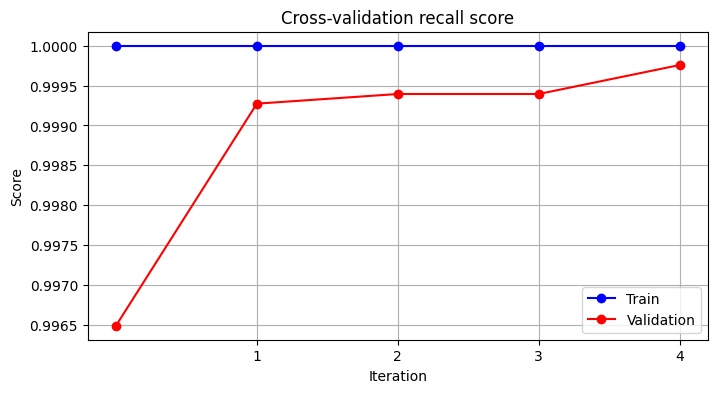

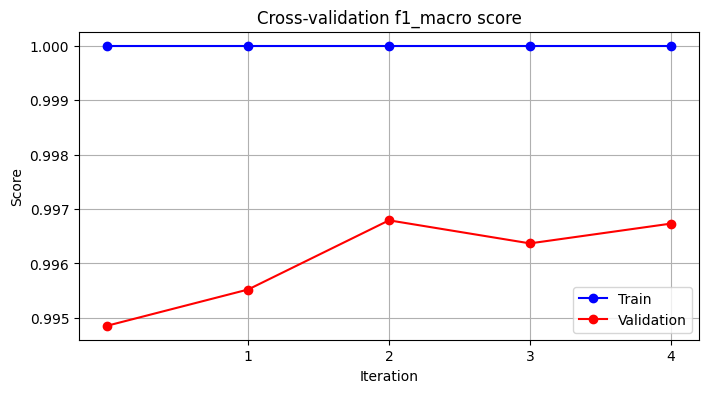

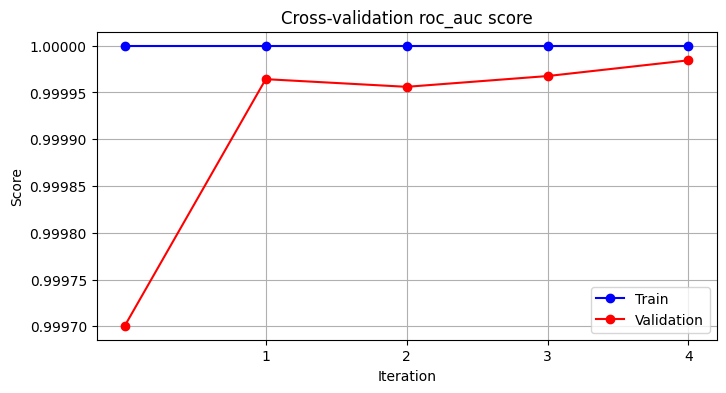

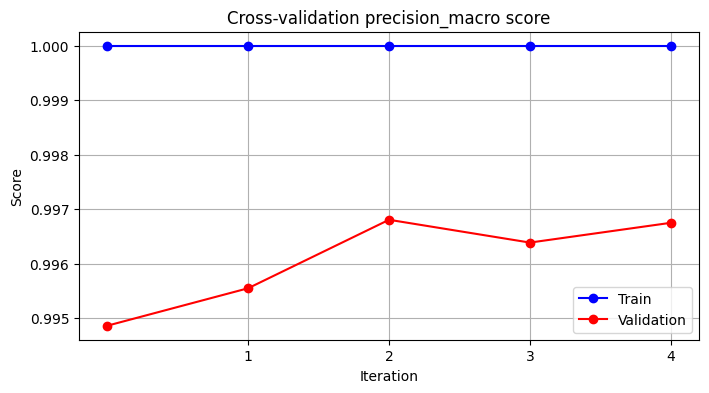

In [30]:
cv_results_rf_clf = cross_validate(estimator=rf_clf,
                                   X=X_train_balanced,
                                   y=y_train_balanced,
                                   scoring=parameters_rf_clf.get('cross_validation')['scores'],
                                   cv=parameters_rf_clf.get('cross_validation')['folders'],
                                   verbose=0,
                                   return_train_score=True,
                                   error_score=np.nan
                                   )

# Calculate cross-validation scores
for score in parameters_rf_clf.get('cross_validation')['scores']:
    cv_train_mean = cv_results_rf_clf[f'train_{score}'].mean().round(4)
    cv_test_mean  = cv_results_rf_clf[f'test_{score}'].mean().round(4)
    plot_cross_validation_score(cv_results_rf_clf, score)
    print(f'>>>>>>>>> CV {score} train mean: {cv_train_mean}')
    print(f'>>>>>>>>> CV {score} test mean:  {cv_test_mean}')

In [31]:
y_pred_rf_clf       = rf_clf.predict(X_val_filled_nan)
y_pred_proba_rf_clf = rf_clf.predict_proba(X_val_filled_nan)

Accuracy:        0.99
Precision:       0.71
Recall:          0.78
F1-score:        0.74
Specificity:     0.99
AUC:             0.89

TN:              17606.00
TP:              232.00
FN:              66.00
FP:              96.00

FP rate:         0.54%
FN rate:         22.15%
False clf rate:  0.90%

No defect cost:  960.00
Predictive cost: 5800.00
Corrective cost: 33000.00
Total cost:      39760.00



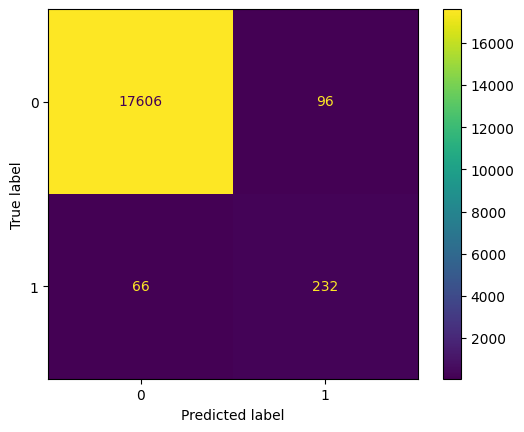

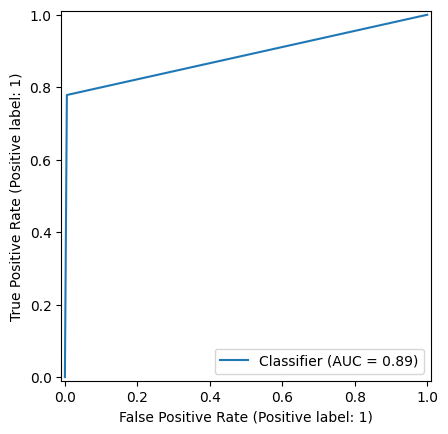

In [136]:
metrics_rf_clf = calculate_metrics_standard_cutoff(y_val, y_pred_rf_clf)

In [33]:
df_pred_proba_rf_clf = pd.DataFrame(y_pred_proba_rf_clf,
                                    columns=['proba_non_event', 'proba_event']
                                    )
df_pred_proba_rf_clf

,proba_non_event,proba_event
0,0.99,0.01
1,0.70,0.30
2,0.85,0.15
3,1.00,0.00
4,0.25,0.75
...,...,...
17995,1.00,0.00
17996,1.00,0.00
17997,1.00,0.00
17998,1.00,0.00


Important metrics

*   Recall: proportion of all actual positives that were classified correctly as positives

*   Specificity: proportion of all actual negative that were classified correctly as negatives

*   Accuracy: proportion of all correctly classified positive and negative instances

*   False classification rate: since false negative classifications are costly, lower values reduce total maintenance costs

*   Total maintenance cost: the main goal of this project is to reduce costs

In [34]:
df_metrics_rf_clf = calculate_metrics_range_cutoff(df_pred_proba_rf_clf, y_val)
df_metrics_rf_clf

,cutoff,accuracy,precision,recall,f1score,auc_value,tn,fp,fn,tp,specificity,false_positive_rate,false_negative_rate,false_classification_rate,no_defect_maintenance_cost,preventive_maintenance_cost,corrective_maintenance_cost,total_maintenance_cost
0,0.05,0.943056,0.221028,0.966443,0.359775,0.954552,16687,1015,10,288,0.942662,5.733815,3.355705,5.694444,10150,7200,5000,22350
1,0.10,0.962278,0.300105,0.959732,0.457234,0.961026,17035,667,12,286,0.962321,3.767936,4.026846,3.772222,6670,7150,6000,19820
2,0.15,0.971722,0.363519,0.942953,0.524743,0.957580,17210,492,17,281,0.972207,2.779347,5.704698,2.827778,4920,7025,8500,20445
3,0.20,0.977722,0.421613,0.929530,0.580105,0.954032,17322,380,21,277,0.978533,2.146650,7.046980,2.227778,3800,6925,10500,21225
4,0.25,0.982167,0.479789,0.916107,0.629758,0.949693,17406,296,25,273,0.983279,1.672127,8.389262,1.783333,2960,6825,12500,22285
5,0.30,0.985167,0.531187,0.885906,0.664151,0.936372,17469,233,34,264,0.986838,1.316235,11.409396,1.483333,2330,6600,17000,25930
6,0.35,0.987278,0.577181,0.865772,0.692617,0.927548,17513,189,40,258,0.989323,1.067676,13.422819,1.272222,1890,6450,20000,28340
7,0.40,0.988778,0.620603,0.828859,0.709770,0.910164,17551,151,51,247,0.991470,0.853011,17.114094,1.122222,1510,6175,25500,33185
8,0.45,0.990000,0.662983,0.805369,0.727273,0.899239,17580,122,58,240,0.993108,0.689188,19.463087,1.000000,1220,6000,29000,36220
9,0.50,0.991000,0.707317,0.778523,0.741214,0.886550,17606,96,66,232,0.994577,0.542312,22.147651,0.900000,960,5800,33000,39760


In [35]:
plot_metrics(df_metrics_rf_clf)

### Tuning

In [36]:
param_dist_rf_clf = create_hyper_parameters_rf_clf(parameters_rf_clf)
param_dist_rf_clf

{'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
        90, 95]),
 'max_depth': array([ 2,  4,  6,  8, 10, 12]),
 'min_samples_split': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 'min_samples_leaf': array([1, 2, 3, 4, 5, 6])}

In [37]:
random_search_rf_clf = RandomizedSearchCV(estimator=rf_clf,
                                          param_distributions=param_dist_rf_clf,
                                          verbose=3,
                                          cv=parameters_rf_clf.get('cross_validation')['folders'],
                                          n_iter=parameters_rf_clf.get('cross_validation')['n_iterations'],
                                          random_state=RANDOM_SEED,
                                          scoring=make_scorer(f1_score)
                                          )
random_search_rf_clf.fit(X_train_balanced, y_train_balanced)

best_params_rf_clf = random_search_rf_clf.best_params_
rf_clf_tuning = RandomForestClassifier(**best_params_rf_clf, random_state=RANDOM_SEED)
rf_clf_tuning.fit(X_train_balanced, y_train_balanced)
print(f'\nBest parameters:\n{best_params_rf_clf}\n')

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END max_depth=6, min_samples_leaf=2, min_samples_split=0.9000000000000001, n_estimators=95;, score=0.667 total time=   0.4s
[CV 2/5] END max_depth=6, min_samples_leaf=2, min_samples_split=0.9000000000000001, n_estimators=95;, score=0.667 total time=   0.4s
[CV 3/5] END max_depth=6, min_samples_leaf=2, min_samples_split=0.9000000000000001, n_estimators=95;, score=0.000 total time=   0.4s
[CV 4/5] END max_depth=6, min_samples_leaf=2, min_samples_split=0.9000000000000001, n_estimators=95;, score=0.667 total time=   0.4s
[CV 5/5] END max_depth=6, min_samples_leaf=2, min_samples_split=0.9000000000000001, n_estimators=95;, score=0.667 total time=   0.4s
[CV 1/5] END max_depth=12, min_samples_leaf=1, min_samples_split=0.5000000000000001, n_estimators=5;, score=0.934 total time=   0.3s
[CV 2/5] END max_depth=12, min_samples_leaf=1, min_samples_split=0.5000000000000001, n_estimators=5;, score=0.908 total time=   0.3s
[CV 3/5] 

#### Cross-validation scores

>>>>>>>>> CV recall train mean: 0.9665
>>>>>>>>> CV recall test mean:  0.9666
>>>>>>>>> CV f1_macro train mean: 0.9515
>>>>>>>>> CV f1_macro test mean:  0.9513
>>>>>>>>> CV roc_auc train mean: 0.9819
>>>>>>>>> CV roc_auc test mean:  0.9819
>>>>>>>>> CV precision_macro train mean: 0.9519
>>>>>>>>> CV precision_macro test mean:  0.9518


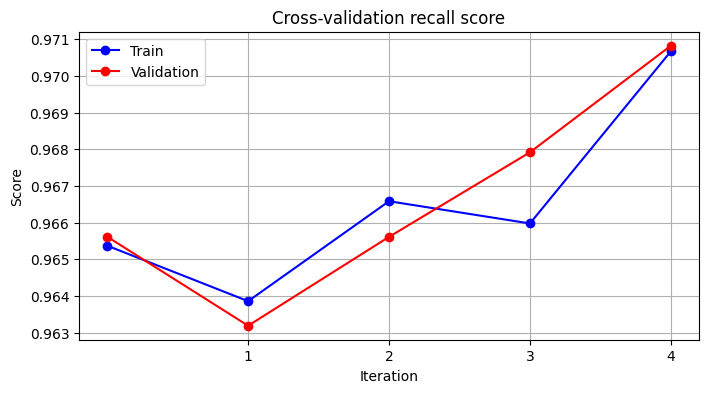

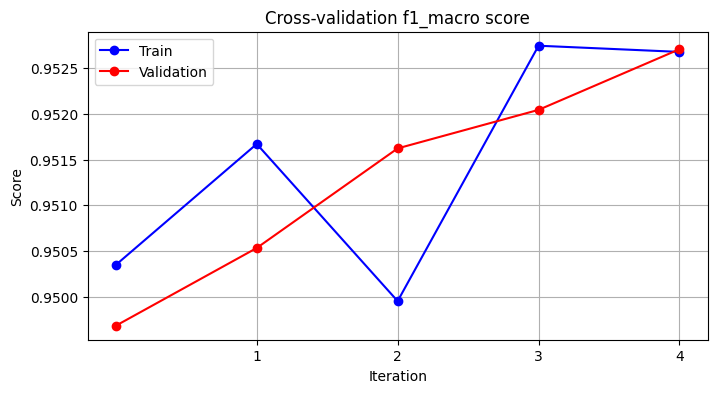

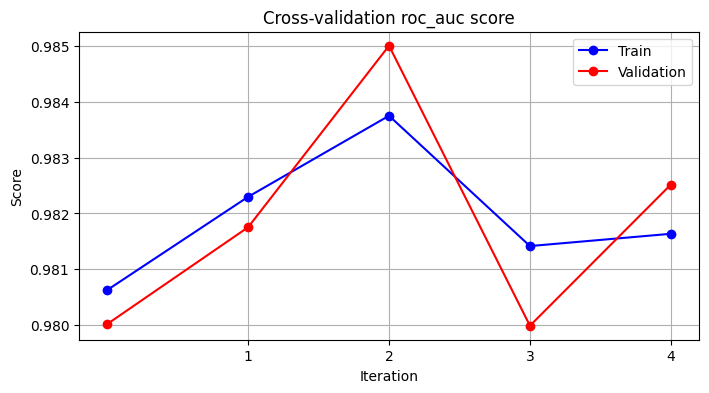

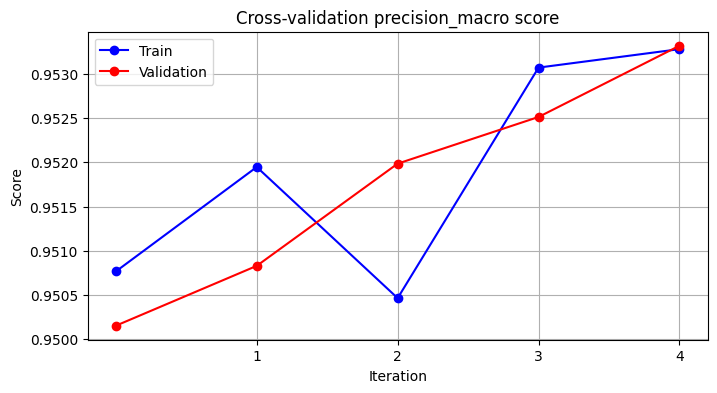

In [38]:
cv_results_rf_clf_tuning = cross_validate(estimator=rf_clf_tuning,
                                          X=X_train_balanced,
                                          y=y_train_balanced,
                                          scoring=parameters_rf_clf.get('cross_validation')['scores'],
                                          cv=parameters_rf_clf.get('cross_validation')['folders'],
                                          verbose=0,
                                          return_train_score=True,
                                          error_score=np.nan
                                          )

# Calculate cross-validation scores
for score in parameters_rf_clf.get('cross_validation')['scores']:
    cv_train_mean = cv_results_rf_clf_tuning[f'train_{score}'].mean().round(4)
    cv_test_mean  = cv_results_rf_clf_tuning[f'test_{score}'].mean().round(4)
    plot_cross_validation_score(cv_results_rf_clf_tuning, score)
    print(f'>>>>>>>>> CV {score} train mean: {cv_train_mean}')
    print(f'>>>>>>>>> CV {score} test mean:  {cv_test_mean}')

In [39]:
y_pred_rf_clf_tuning       = rf_clf_tuning.predict(X_val_filled_nan)
y_pred_proba_rf_clf_tuning = rf_clf_tuning.predict_proba(X_val_filled_nan)

Accuracy:        0.94
Precision:       0.21
Recall:          0.96
F1-score:        0.35
Specificity:     0.94
AUC:             0.95

TN:              16625.00
TP:              287.00
FN:              11.00
FP:              1077.00

FP rate:         6.08%
FN rate:         3.69%
False clf rate:  6.04%

No defect cost:  10770.00
Predictive cost: 7175.00
Corrective cost: 5500.00
Total cost:      23445.00



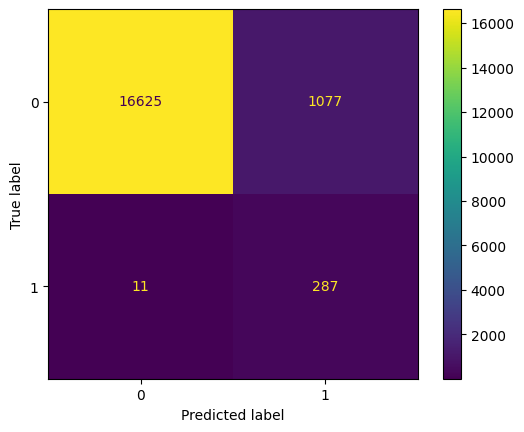

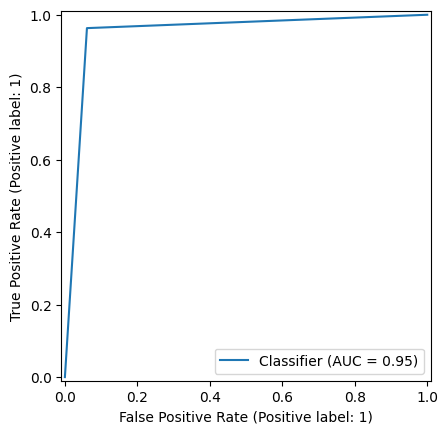

In [40]:
metrics_rf_clf_tuning = calculate_metrics_standard_cutoff(y_val, y_pred_rf_clf_tuning)

In [41]:
df_pred_proba_rf_clf_tuning = pd.DataFrame(y_pred_proba_rf_clf_tuning,
                                           columns=['proba_non_event', 'proba_event']
                                           )
df_metrics_rf_clf_tuning = calculate_metrics_range_cutoff(df_pred_proba_rf_clf_tuning, y_val)
df_metrics_rf_clf_tuning
plot_metrics(df_metrics_rf_clf_tuning)

### Feature importance

,feature,importance
136,cs_002,0.000346
142,ap_000,0.000550
72,ba_003,0.000551
106,ee_002,0.000583
10,db_000,0.000734


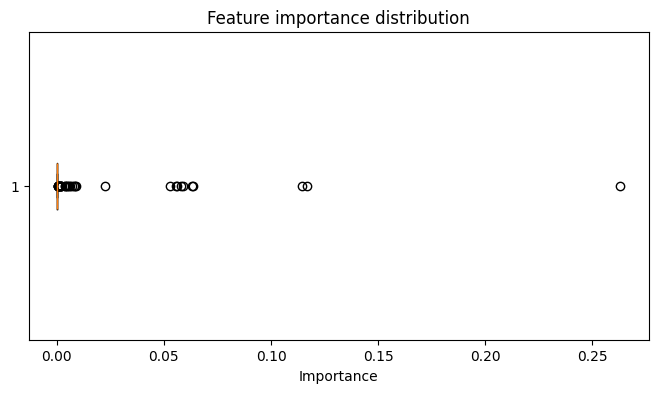

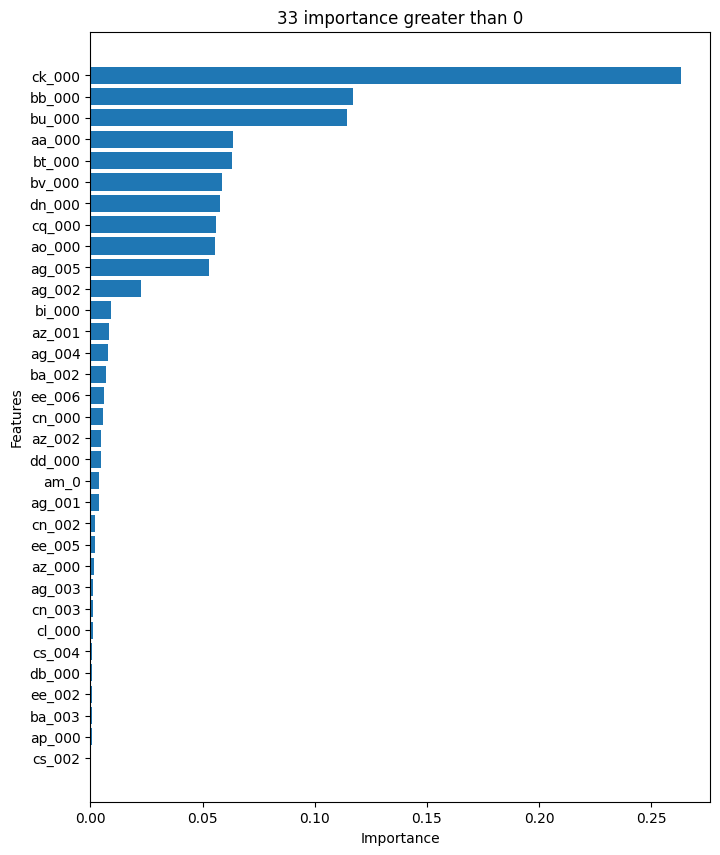

In [42]:
df_feat_importance_rf_clf = calculate_feature_importance(rf_clf_tuning)
df_feat_importance_rf_clf.head()

In [43]:
important_features_rf_clf         = df_feat_importance_rf_clf['feature'].to_list()
X_train_important_features_rf_clf = X_train_balanced[important_features_rf_clf]
X_val_important_features_rf_clf   = X_val_filled_nan[important_features_rf_clf]

rf_clf_tuning.fit(X_train_important_features_rf_clf, y_train_balanced)

RandomForestClassifier(max_depth=np.int64(8), min_samples_leaf=np.int64(2),
                       min_samples_split=np.float64(0.30000000000000004),
                       n_estimators=np.int64(15))

#### Cross-validation scores

>>>>>>>>> CV recall train mean: 0.9688
>>>>>>>>> CV recall test mean:  0.9686
>>>>>>>>> CV f1_macro train mean: 0.9515
>>>>>>>>> CV f1_macro test mean:  0.9515
>>>>>>>>> CV roc_auc train mean: 0.9786
>>>>>>>>> CV roc_auc test mean:  0.9785
>>>>>>>>> CV precision_macro train mean: 0.952
>>>>>>>>> CV precision_macro test mean:  0.952


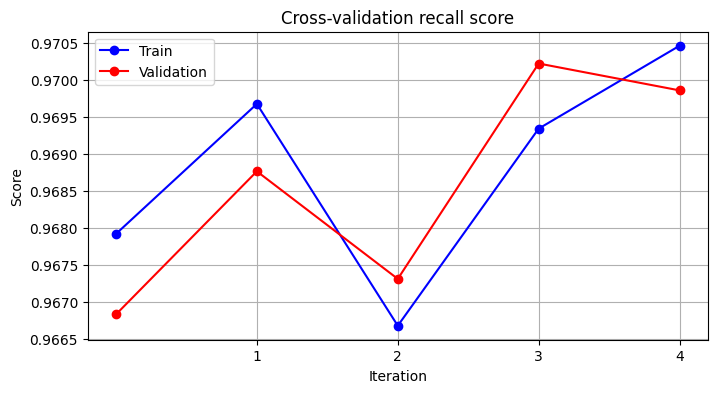

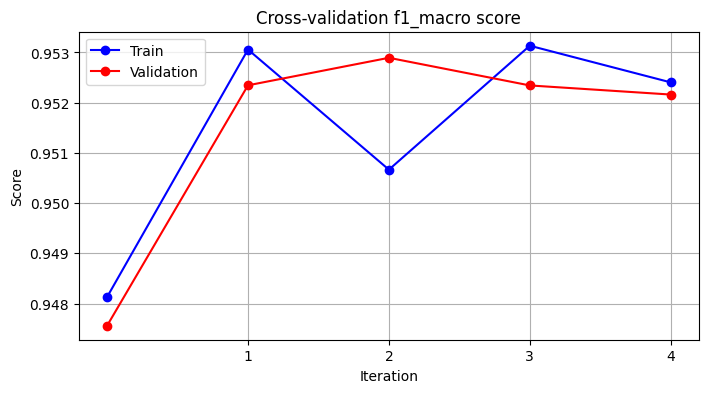

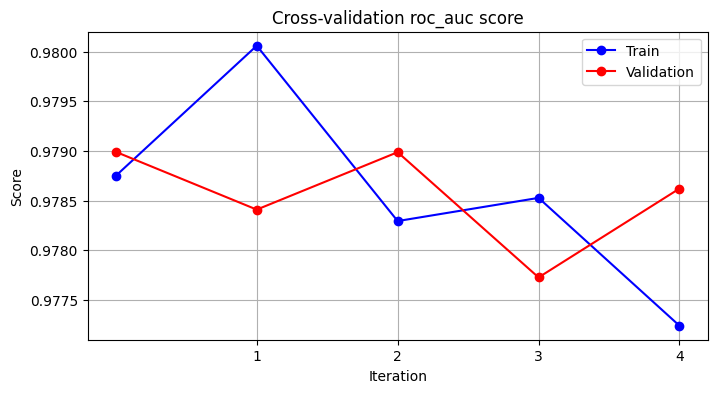

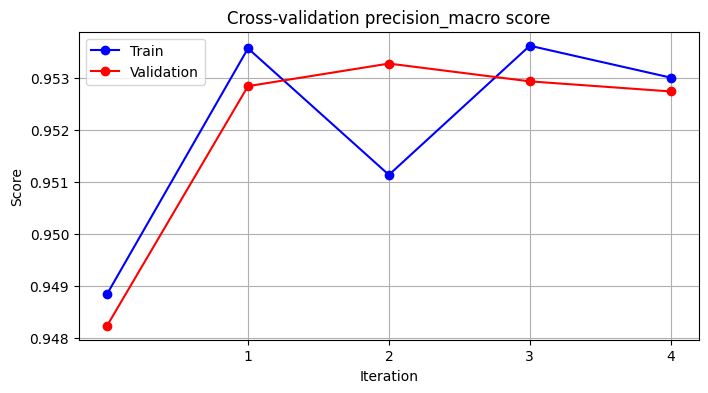

In [44]:
cv_results_rf_clf_important_features = cross_validate(estimator=rf_clf_tuning,
                                                      X=X_train_important_features_rf_clf,
                                                      y=y_train_balanced,
                                                      scoring=parameters_rf_clf.get('cross_validation')['scores'],
                                                      cv=parameters_rf_clf.get('cross_validation')['folders'],
                                                      verbose=0,
                                                      return_train_score=True,
                                                      error_score=np.nan
                                                      )

# Calculate cross-validation scores
for score in parameters_rf_clf.get('cross_validation')['scores']:
    cv_train_mean = cv_results_rf_clf_important_features[f'train_{score}'].mean().round(4)
    cv_test_mean  = cv_results_rf_clf_important_features[f'test_{score}'].mean().round(4)
    plot_cross_validation_score(cv_results_rf_clf_important_features, score)
    print(f'>>>>>>>>> CV {score} train mean: {cv_train_mean}')
    print(f'>>>>>>>>> CV {score} test mean:  {cv_test_mean}')

In [45]:
y_pred_rf_clf_important_features       = rf_clf_tuning.predict(X_val_important_features_rf_clf)
y_pred_proba_rf_clf_important_features = rf_clf_tuning.predict_proba(X_val_important_features_rf_clf)

Accuracy:        0.94
Precision:       0.21
Recall:          0.96
F1-score:        0.35
Specificity:     0.94
AUC:             0.95

TN:              16654.00
TP:              286.00
FN:              12.00
FP:              1048.00

FP rate:         5.92%
FN rate:         4.03%
False clf rate:  5.89%

No defect cost:  10480.00
Predictive cost: 7150.00
Corrective cost: 6000.00
Total cost:      23630.00



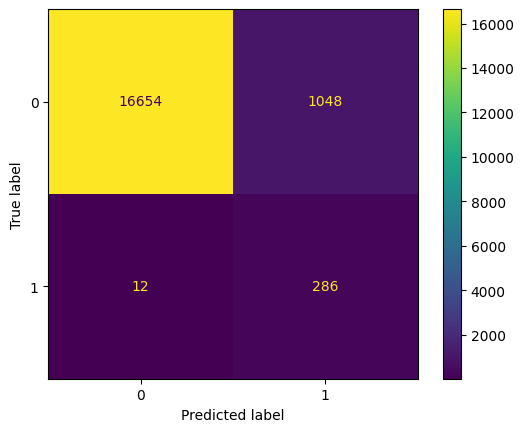

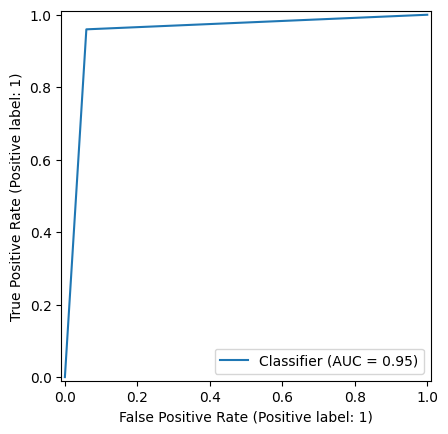

In [46]:
metrics_rf_clf_important_features = calculate_metrics_standard_cutoff(y_val, y_pred_rf_clf_important_features)

In [47]:
df_pred_proba_rf_clf_important_features = pd.DataFrame(y_pred_proba_rf_clf_important_features,
                                                       columns=['proba_non_event', 'proba_event']
                                                       )
df_metrics_rf_clf_important_features = calculate_metrics_range_cutoff(df_pred_proba_rf_clf_important_features, y_val)
df_metrics_rf_clf_important_features
plot_metrics(df_metrics_rf_clf_important_features)

## XGBoost

In [48]:
parameters_xgb_clf = {
    "model_parameters": {
        "n_estimators": [60, 80],
        "max_depth": [10, 13],
        "learning_rate": [0.05, 0.1],
        "subsample": [0.8, 1],
        "colsample_bytree": [0.6, 1]
    },
    "cross_validation": {
        "n_iterations": 10,
        "folders": 5,
        "scores": [
            "accuracy",
            "f1_macro",
            "roc_auc",
            "precision_macro"
        ]
    },
    "maintenance_cost": {
        "no_defect_cost": 10,
        "preventive_cost": 25,
        "corrective_cost": 500
    },
    "target": "class",
    "cutoff": 0.3,
    "model_name": "xgb_clf",
    "predict_method": "predict_proba"
}

In [49]:
def create_hyper_parameters_range_xgb(parameters: dict):
    range_n_estimators = np.arange(start=round(parameters.get('model_parameters')['n_estimators'][0], 2),
                                   stop=round(parameters.get('model_parameters')['n_estimators'][-1], 2),
                                   step=2
                                   )
    range_max_depth = np.arange(start=round(parameters.get('model_parameters')['max_depth'][0], 2),
                                stop=round(parameters.get('model_parameters')['max_depth'][-1], 2),
                                step=1
                                )
    range_learning_rate = np.arange(start=round(parameters.get('model_parameters')['learning_rate'][0], 2),
                                    stop=round(parameters.get('model_parameters')['learning_rate'][-1], 2),
                                    step=0.01
                                    )
    range_subsample = np.arange(start=round(parameters.get('model_parameters')['subsample'][0], 2),
                                stop=round(parameters.get('model_parameters')['subsample'][-1], 2),
                                step=0.015
                                )
    range_colsample_bytree = np.arange(start=round(parameters.get('model_parameters')['colsample_bytree'][0], 2),
                                       stop=round(parameters.get('model_parameters')['colsample_bytree'][-1], 2),
                                       step=0.05
                                       )
    param_distributions = {'n_estimators'     : range_n_estimators,
                           'max_depth'        : range_max_depth,
                           'learning_rate'    : range_learning_rate,
                           'subsample'        : range_subsample,
                           'colsample_bytree' :range_colsample_bytree
                          }
    
    return param_distributions

### Simple model

In [50]:
xgb_clf = XGBClassifier(random_state=RANDOM_SEED, verbosity=0)
xgb_clf.fit(X_train_balanced, y_train_balanced)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

#### Cross-validation scores

>>>>>>>>> CV accuracy train mean: 1.0
>>>>>>>>> CV accuracy test mean:  0.9974
>>>>>>>>> CV f1_macro train mean: 1.0
>>>>>>>>> CV f1_macro test mean:  0.9974
>>>>>>>>> CV roc_auc train mean: 1.0
>>>>>>>>> CV roc_auc test mean:  0.9999
>>>>>>>>> CV precision_macro train mean: 1.0
>>>>>>>>> CV precision_macro test mean:  0.9974


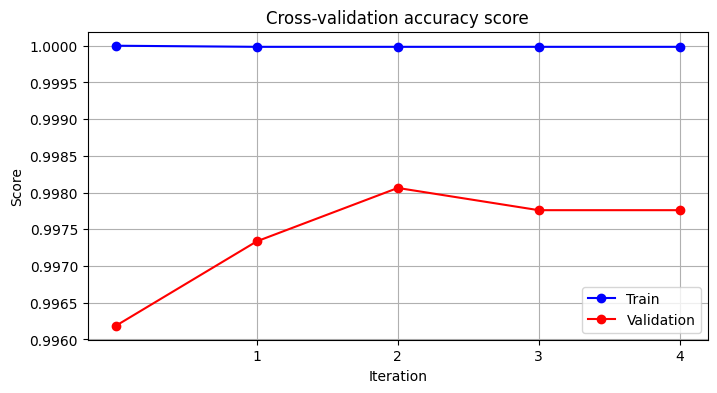

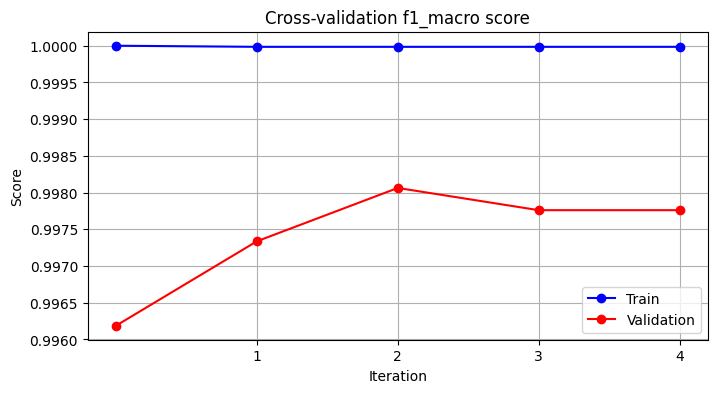

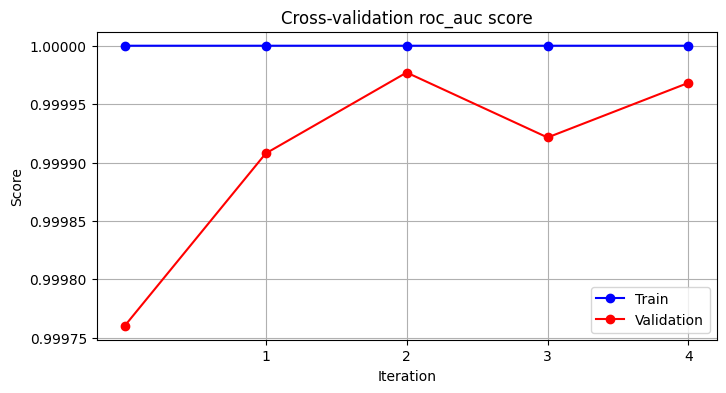

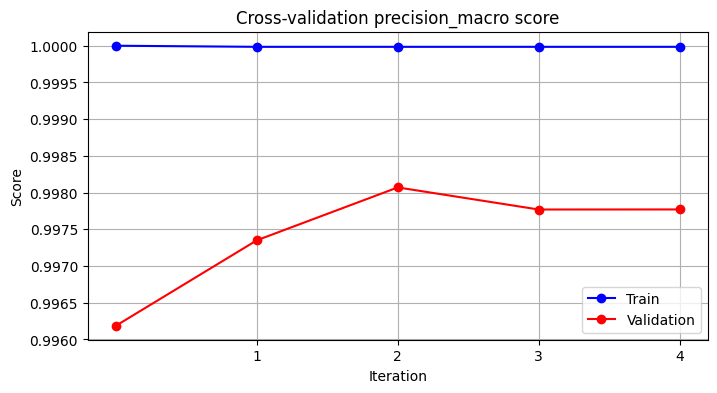

In [51]:
cv_results_xgb_clf = cross_validate(estimator=xgb_clf,
                                    X=X_train_balanced,
                                    y=y_train_balanced,
                                    scoring=parameters_xgb_clf.get('cross_validation')['scores'],
                                    cv=parameters_xgb_clf.get('cross_validation')['folders'],
                                    verbose=0,
                                    return_train_score=True,
                                    error_score=np.nan
                                    )

# Calculate cross-validation scores
for score in parameters_xgb_clf.get('cross_validation')['scores']:
    cv_train_mean = cv_results_xgb_clf[f'train_{score}'].mean().round(4)
    cv_test_mean  = cv_results_xgb_clf[f'test_{score}'].mean().round(4)
    plot_cross_validation_score(cv_results_xgb_clf, score)
    print(f'>>>>>>>>> CV {score} train mean: {cv_train_mean}')
    print(f'>>>>>>>>> CV {score} test mean:  {cv_test_mean}')

In [52]:
y_pred_xgb_clf       = xgb_clf.predict(X_val_filled_nan)
y_pred_proba_xgb_clf = xgb_clf.predict_proba(X_val_filled_nan)

Accuracy:        0.99
Precision:       0.78
Recall:          0.79
F1-score:        0.78
Specificity:     1.00
AUC:             0.89

TN:              17634.00
TP:              236.00
FN:              62.00
FP:              68.00

FP rate:         0.38%
FN rate:         20.81%
False clf rate:  0.72%

No defect cost:  680.00
Predictive cost: 5900.00
Corrective cost: 31000.00
Total cost:      37580.00



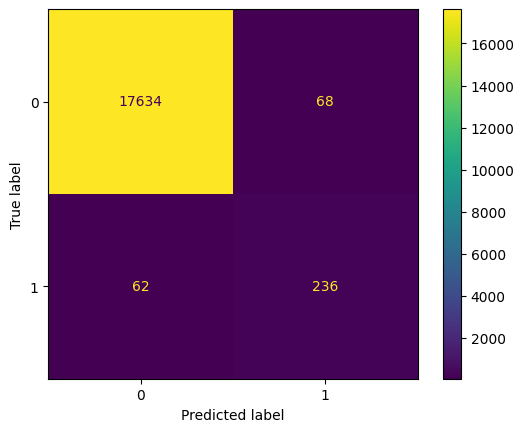

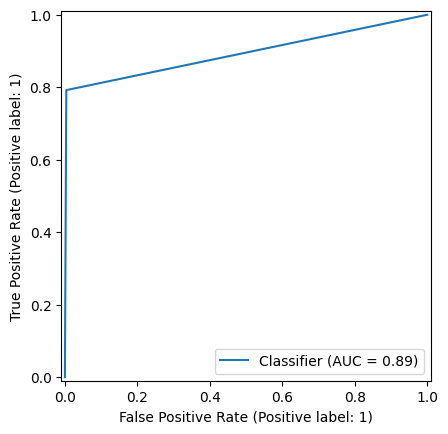

In [53]:
metrics_xgb_clf = calculate_metrics_standard_cutoff(y_val, y_pred_xgb_clf)

In [54]:
df_pred_proba_xgb_clf = pd.DataFrame(y_pred_proba_xgb_clf,
                                     columns=['proba_non_event', 'proba_event']
                                     )
df_metrics_xgb_clf = calculate_metrics_range_cutoff(df_pred_proba_xgb_clf, y_val)
plot_metrics(df_metrics_xgb_clf)

### Tuning

In [55]:
param_dist_xgb_clf = create_hyper_parameters_range_xgb(parameters_xgb_clf)
param_dist_xgb_clf

{'n_estimators': array([60, 62, 64, 66, 68, 70, 72, 74, 76, 78]),
 'max_depth': array([10, 11, 12]),
 'learning_rate': array([0.05, 0.06, 0.07, 0.08, 0.09]),
 'subsample': array([0.8  , 0.815, 0.83 , 0.845, 0.86 , 0.875, 0.89 , 0.905, 0.92 ,
        0.935, 0.95 , 0.965, 0.98 , 0.995]),
 'colsample_bytree': array([0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])}

In [56]:
random_search_xgb_clf = RandomizedSearchCV(estimator=xgb_clf,
                                           param_distributions=param_dist_xgb_clf,
                                           verbose=3,
                                           cv=parameters_xgb_clf.get('cross_validation')['folders'],
                                           n_iter=parameters_xgb_clf.get('cross_validation')['n_iterations'],
                                           random_state=RANDOM_SEED,
                                           scoring=make_scorer(f1_score)
                                           )
random_search_xgb_clf.fit(X_train_balanced, y_train_balanced)

best_params_xgb_clf = random_search_xgb_clf.best_params_
xgb_clf_tuning = XGBClassifier(**best_params_xgb_clf, random_state=RANDOM_SEED)
xgb_clf_tuning.fit(X_train_balanced, y_train_balanced)
print(f'\nBest parameters:\n{best_params_xgb_clf}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END colsample_bytree=0.9000000000000002, learning_rate=0.05, max_depth=11, n_estimators=72, subsample=0.8750000000000001;, score=0.994 total time=   8.9s
[CV 2/5] END colsample_bytree=0.9000000000000002, learning_rate=0.05, max_depth=11, n_estimators=72, subsample=0.8750000000000001;, score=0.995 total time=   9.0s
[CV 3/5] END colsample_bytree=0.9000000000000002, learning_rate=0.05, max_depth=11, n_estimators=72, subsample=0.8750000000000001;, score=0.996 total time=   9.8s
[CV 4/5] END colsample_bytree=0.9000000000000002, learning_rate=0.05, max_depth=11, n_estimators=72, subsample=0.8750000000000001;, score=0.994 total time=   9.1s
[CV 5/5] END colsample_bytree=0.9000000000000002, learning_rate=0.05, max_depth=11, n_estimators=72, subsample=0.8750000000000001;, score=0.995 total time=   9.5s
[CV 1/5] END colsample_bytree=0.8500000000000002, learning_rate=0.07, max_depth=12, n_estimators=74, subsample=0.81500000000

#### Cross-validation scores

>>>>>>>>> CV accuracy train mean: 0.9998
>>>>>>>>> CV accuracy test mean:  0.9963
>>>>>>>>> CV f1_macro train mean: 0.9998
>>>>>>>>> CV f1_macro test mean:  0.9963
>>>>>>>>> CV roc_auc train mean: 1.0
>>>>>>>>> CV roc_auc test mean:  0.9999
>>>>>>>>> CV precision_macro train mean: 0.9998
>>>>>>>>> CV precision_macro test mean:  0.9963


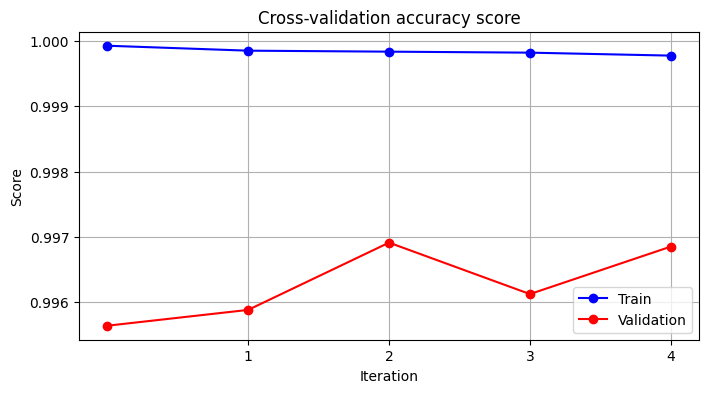

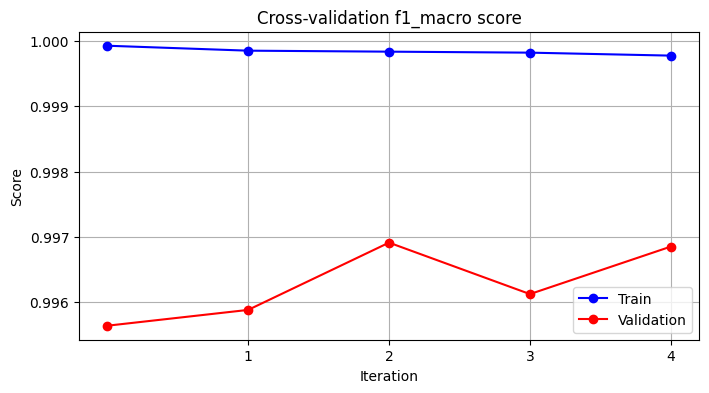

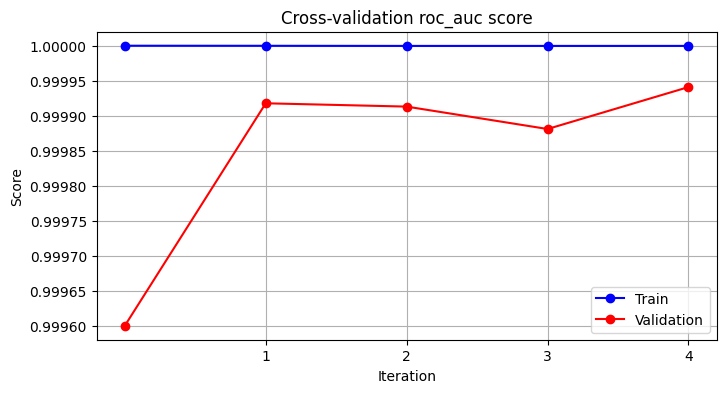

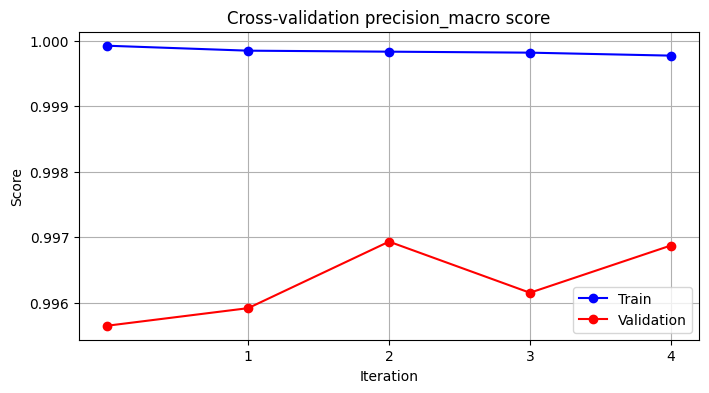

In [57]:
cv_results_xgb_clf_tuning = cross_validate(estimator=xgb_clf_tuning,
                                           X=X_train_balanced,
                                           y=y_train_balanced,
                                           scoring=parameters_xgb_clf.get('cross_validation')['scores'],
                                           cv=parameters_xgb_clf.get('cross_validation')['folders'],
                                           verbose=0,
                                           return_train_score=True,
                                           error_score=np.nan
                                           )

# Calculate cross-validation scores
for score in parameters_xgb_clf.get('cross_validation')['scores']:
    cv_train_mean = cv_results_xgb_clf_tuning[f'train_{score}'].mean().round(4)
    cv_test_mean  = cv_results_xgb_clf_tuning[f'test_{score}'].mean().round(4)
    plot_cross_validation_score(cv_results_xgb_clf_tuning, score)
    print(f'>>>>>>>>> CV {score} train mean: {cv_train_mean}')
    print(f'>>>>>>>>> CV {score} test mean:  {cv_test_mean}')

In [58]:
y_pred_xgb_clf_tuning       = xgb_clf.predict(X_val_filled_nan)
y_pred_proba_xgb_clf_tuning = xgb_clf.predict_proba(X_val_filled_nan)

Accuracy:        0.99
Precision:       0.78
Recall:          0.79
F1-score:        0.78
Specificity:     1.00
AUC:             0.89

TN:              17634.00
TP:              236.00
FN:              62.00
FP:              68.00

FP rate:         0.38%
FN rate:         20.81%
False clf rate:  0.72%

No defect cost:  680.00
Predictive cost: 5900.00
Corrective cost: 31000.00
Total cost:      37580.00



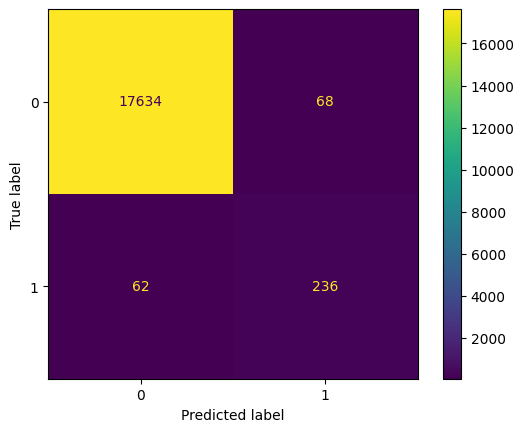

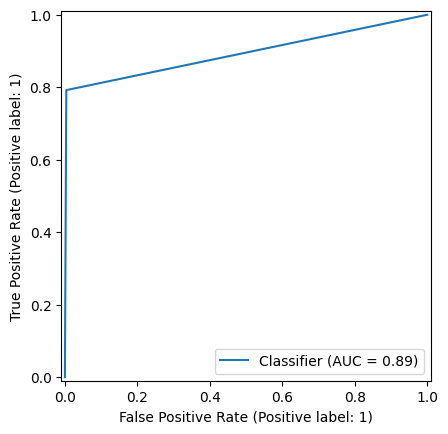

In [59]:
metrics_xgb_clf_tuning = calculate_metrics_standard_cutoff(y_val, y_pred_xgb_clf_tuning)

In [60]:
df_pred_proba_xgb_clf_tuning = pd.DataFrame(y_pred_proba_xgb_clf_tuning,
                                            columns=['proba_non_event', 'proba_event']
                                           )
df_metrics_xgb_clf_tuning = calculate_metrics_range_cutoff(df_pred_proba_xgb_clf_tuning, y_val)
df_metrics_xgb_clf_tuning
plot_metrics(df_metrics_xgb_clf_tuning)

### Feature importance

,feature,importance
13,da_000,0.000080
144,bg_000,0.000127
130,cs_006,0.000171
6,ad_000,0.000183
75,ba_001,0.000244


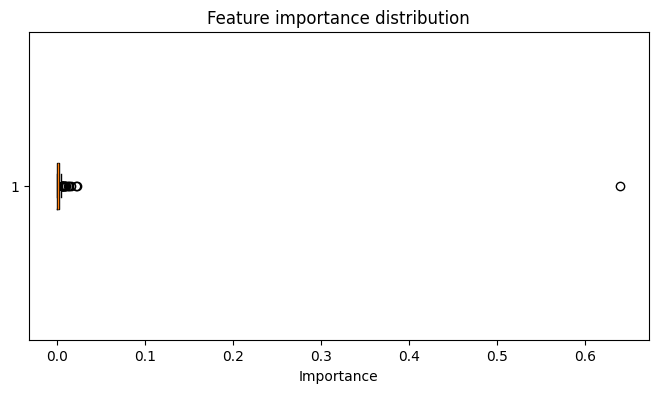

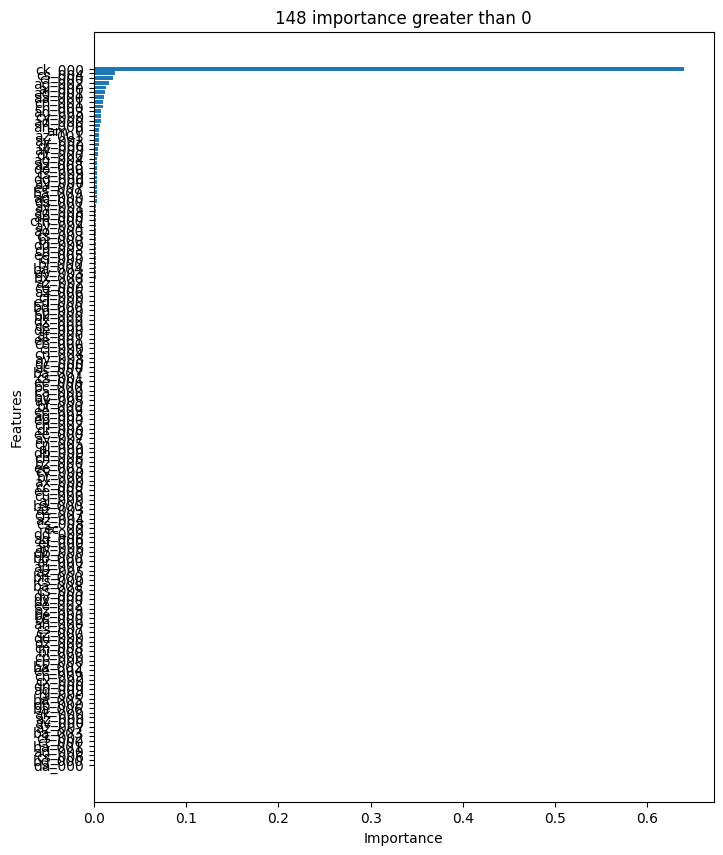

In [61]:
df_feat_importance_xgb_clf = calculate_feature_importance(xgb_clf)
df_feat_importance_xgb_clf.head()

In [62]:
important_features_xgb_clf         = df_feat_importance_xgb_clf['feature'].to_list()
X_train_important_features_xgb_clf = X_train_balanced[important_features_xgb_clf]
X_val_important_features_xgb_clf   = X_val_filled_nan[important_features_xgb_clf]

xgb_clf_tuning.fit(X_train_important_features_xgb_clf, y_train_balanced)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.7000000000000001), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None,
              learning_rate=np.float64(0.09000000000000001), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=np.int64(10), max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=np.int64(72), n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

#### Cross-validation scores

>>>>>>>>> CV accuracy train mean: 0.9998
>>>>>>>>> CV accuracy test mean:  0.9962
>>>>>>>>> CV f1_macro train mean: 0.9998
>>>>>>>>> CV f1_macro test mean:  0.9962
>>>>>>>>> CV roc_auc train mean: 1.0
>>>>>>>>> CV roc_auc test mean:  0.9999
>>>>>>>>> CV precision_macro train mean: 0.9998
>>>>>>>>> CV precision_macro test mean:  0.9963


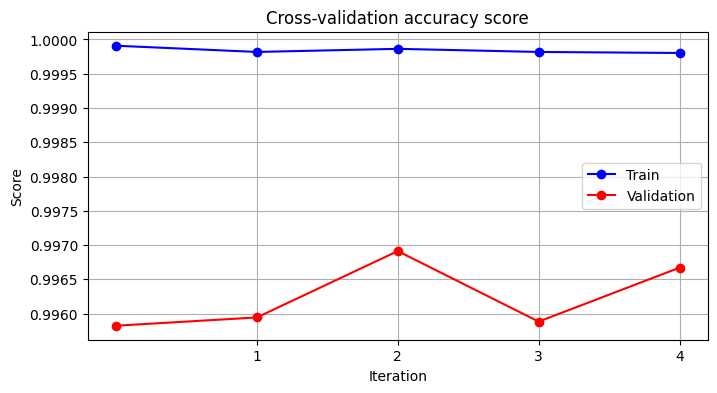

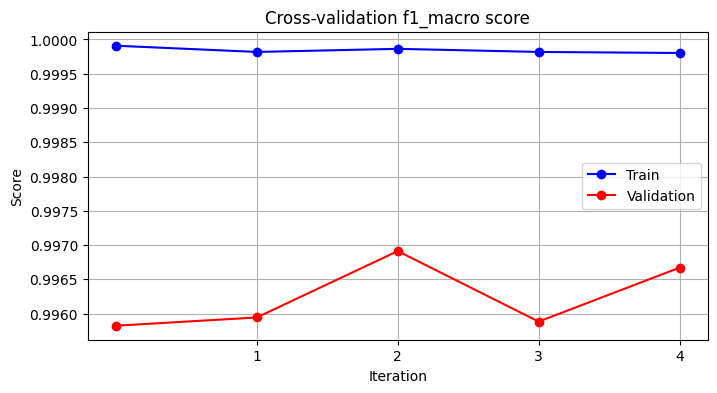

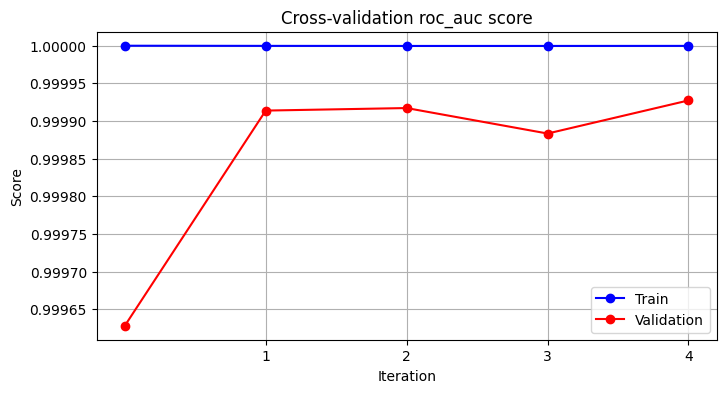

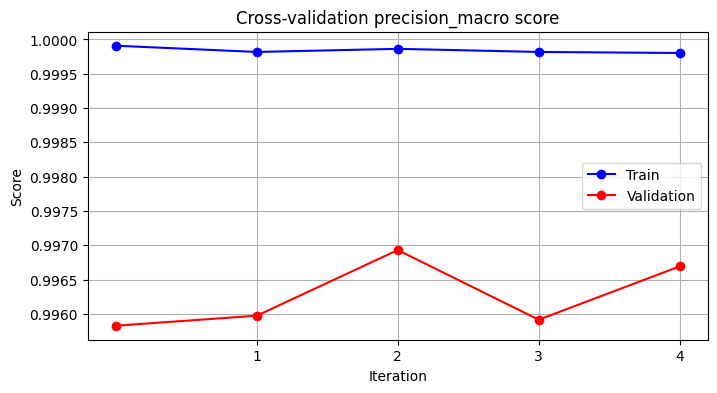

In [63]:
cv_results_xgb_clf_important_features = cross_validate(estimator=xgb_clf_tuning,
                                                       X=X_train_important_features_xgb_clf,
                                                       y=y_train_balanced,
                                                       scoring=parameters_xgb_clf.get('cross_validation')['scores'],
                                                       cv=parameters_xgb_clf.get('cross_validation')['folders'],
                                                       verbose=0,
                                                       return_train_score=True,
                                                       error_score=np.nan
                                                       )

# Calculate cross-validation scores
for score in parameters_xgb_clf.get('cross_validation')['scores']:
    cv_train_mean = cv_results_xgb_clf_important_features[f'train_{score}'].mean().round(4)
    cv_test_mean  = cv_results_xgb_clf_important_features[f'test_{score}'].mean().round(4)
    plot_cross_validation_score(cv_results_xgb_clf_important_features, score)
    print(f'>>>>>>>>> CV {score} train mean: {cv_train_mean}')
    print(f'>>>>>>>>> CV {score} test mean:  {cv_test_mean}')

In [64]:
y_pred_xgb_clf_important_features       = xgb_clf_tuning.predict(X_val_important_features_xgb_clf)
y_pred_proba_xgb_clf_important_features = xgb_clf_tuning.predict_proba(X_val_important_features_xgb_clf)

Accuracy:        0.99
Precision:       0.67
Recall:          0.80
F1-score:        0.73
Specificity:     0.99
AUC:             0.90

TN:              17587.00
TP:              238.00
FN:              60.00
FP:              115.00

FP rate:         0.65%
FN rate:         20.13%
False clf rate:  0.97%

No defect cost:  1150.00
Predictive cost: 5950.00
Corrective cost: 30000.00
Total cost:      37100.00



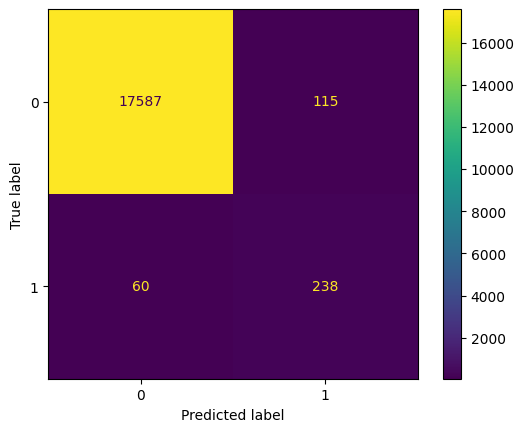

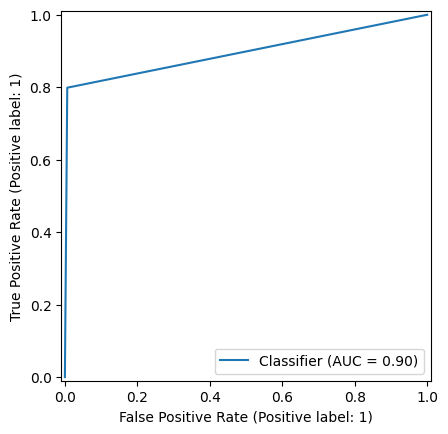

In [65]:
metrics_xgb_clf_important_features = calculate_metrics_standard_cutoff(y_val, y_pred_xgb_clf_important_features)

In [66]:
df_pred_proba_xgb_clf_important_features = pd.DataFrame(y_pred_proba_xgb_clf_important_features,
                                                        columns=['proba_non_event', 'proba_event']
                                                       )
df_metrics_xgb_clf_important_features = calculate_metrics_range_cutoff(df_pred_proba_xgb_clf_important_features, y_val)
df_metrics_xgb_clf_important_features
plot_metrics(df_metrics_xgb_clf_important_features)

## MLPClassifier

In [67]:
scaler = StandardScaler()
scaler.fit(X_train_balanced)

X_train_scaled = scaler.transform(X_train_balanced)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_balanced.columns)
df_train_scaled = df_target.join(X_train_scaled)
df_train_scaled.rename(columns={'class': 'target'}, inplace=True)

X_val_scaled = scaler.transform(X_val_filled_nan)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val_filled_nan.columns)

In [68]:
parameters_mlp_clf = {'hyper_parameters': {'hidden_layer_sizes': [(200), (100, 50), (200, 100, 50)],
                                           'max_iter': [500, 1000],
                                           'activation': ['relu'],
                                           'solver': ['adam'],
                                           'alpha': [0.0001, 0.001],
                                           'learning_rate': ['adaptive']
                                          },
                      "cross_validation": {"n_iterations": 5,
                                           "folders": 5,
                                           "scores": [
                                               "recall",
                                               "f1_macro",
                                               "roc_auc",
                                               "precision_macro"]
                                          }
                      }

### Simple model

In [69]:
mlp_clf = MLPClassifier()
mlp_clf.fit(X_train_scaled, y_train_balanced)

MLPClassifier()

#### Cross-validation scores

>>>>>>>>> CV recall train mean: 0.9983
>>>>>>>>> CV recall test mean:  0.9982
>>>>>>>>> CV f1_macro train mean: 0.9984
>>>>>>>>> CV f1_macro test mean:  0.9959
>>>>>>>>> CV roc_auc train mean: 1.0
>>>>>>>>> CV roc_auc test mean:  0.9993
>>>>>>>>> CV precision_macro train mean: 0.9984
>>>>>>>>> CV precision_macro test mean:  0.9959


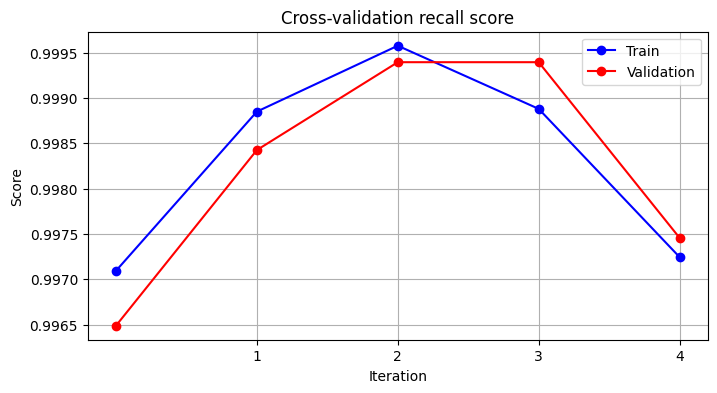

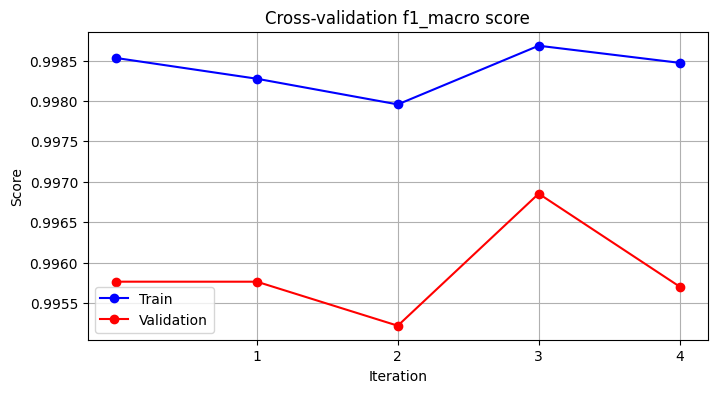

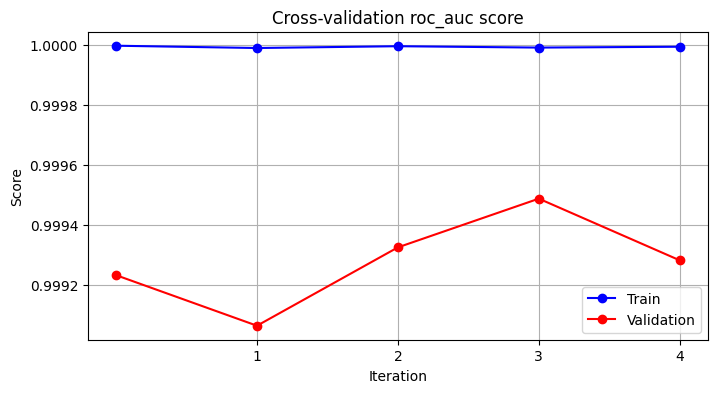

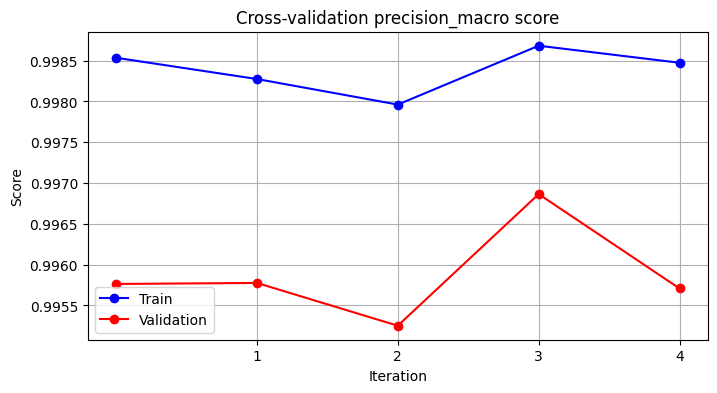

In [70]:
cv_results_mlp_clf = cross_validate(estimator=mlp_clf,
                                    X=X_train_scaled,
                                    y=y_train_balanced,
                                    scoring=parameters_mlp_clf.get('cross_validation')['scores'],
                                    cv=parameters_mlp_clf.get('cross_validation')['folders'],
                                    verbose=0,
                                    return_train_score=True,
                                    error_score=np.nan
                                    )

# Calculate cross-validation scores
for score in parameters_mlp_clf.get('cross_validation')['scores']:
    cv_train_mean = cv_results_mlp_clf[f'train_{score}'].mean().round(4)
    cv_test_mean  = cv_results_mlp_clf[f'test_{score}'].mean().round(4)
    plot_cross_validation_score(cv_results_mlp_clf, score)
    print(f'>>>>>>>>> CV {score} train mean: {cv_train_mean}')
    print(f'>>>>>>>>> CV {score} test mean:  {cv_test_mean}')

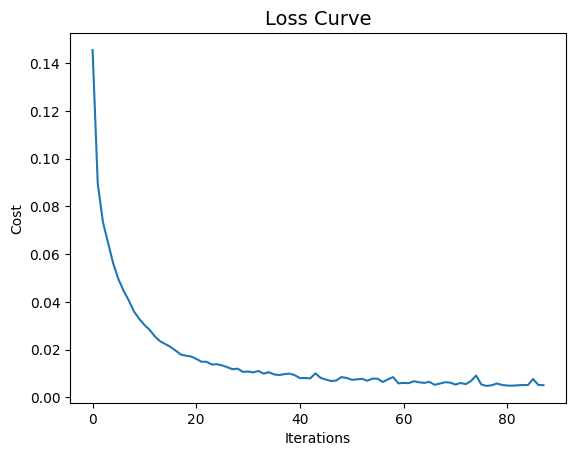

In [71]:
plt.plot(mlp_clf.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

In [72]:
y_pred_mlp_clf       = mlp_clf.predict(X_val_scaled)
y_pred_proba_mlp_clf = mlp_clf.predict_proba(X_val_scaled)

Accuracy:        0.99
Precision:       0.70
Recall:          0.69
F1-score:        0.69
Specificity:     1.00
AUC:             0.84

TN:              17615.00
TP:              205.00
FN:              93.00
FP:              87.00

FP rate:         0.49%
FN rate:         31.21%
False clf rate:  1.00%

No defect cost:  870.00
Predictive cost: 5125.00
Corrective cost: 46500.00
Total cost:      52495.00



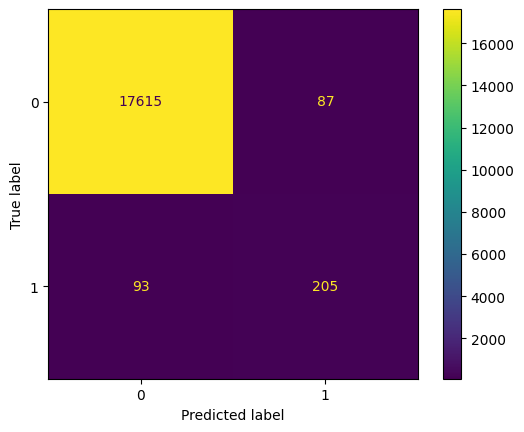

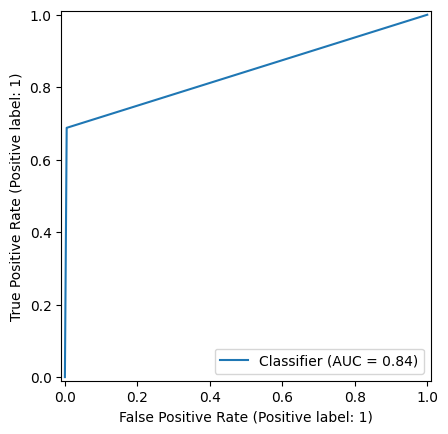

In [73]:
metrics_mlp_clf = calculate_metrics_standard_cutoff(y_val, y_pred_mlp_clf)

In [74]:
df_pred_proba_mlp_clf = pd.DataFrame(y_pred_proba_mlp_clf,
                                     columns=['proba_non_event', 'proba_event']
                                     )
df_metrics_mlp_clf = calculate_metrics_range_cutoff(df_pred_proba_mlp_clf, y_val)
plot_metrics(df_metrics_mlp_clf)

## AdaBoosting

### Random forest

In [75]:
ada_rf_clf = AdaBoostClassifier(estimator=RandomForestClassifier(verbose=0, random_state=RANDOM_SEED),
                                random_state=RANDOM_SEED,
                                algorithm='SAMME'
                               )
ada_rf_clf.fit(X_train_scaled, y_train_balanced)

AdaBoostClassifier(algorithm='SAMME', estimator=RandomForestClassifier())

#### Cross-validation scores

>>>>>>>>> CV recall train mean: 1.0
>>>>>>>>> CV recall test mean:  0.9988
>>>>>>>>> CV f1_macro train mean: 1.0
>>>>>>>>> CV f1_macro test mean:  0.996
>>>>>>>>> CV roc_auc train mean: 1.0
>>>>>>>>> CV roc_auc test mean:  0.996
>>>>>>>>> CV precision_macro train mean: 1.0
>>>>>>>>> CV precision_macro test mean:  0.996


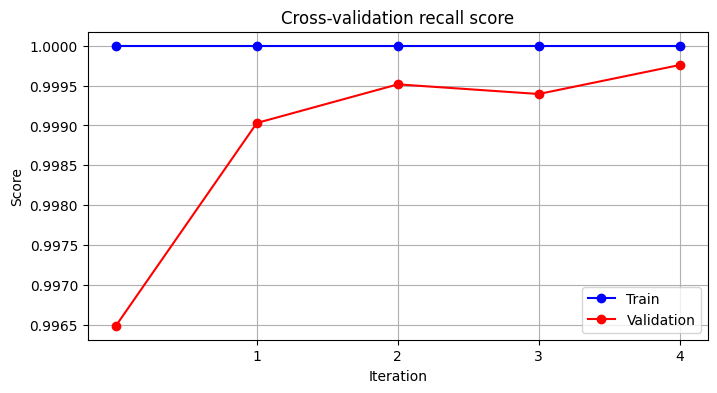

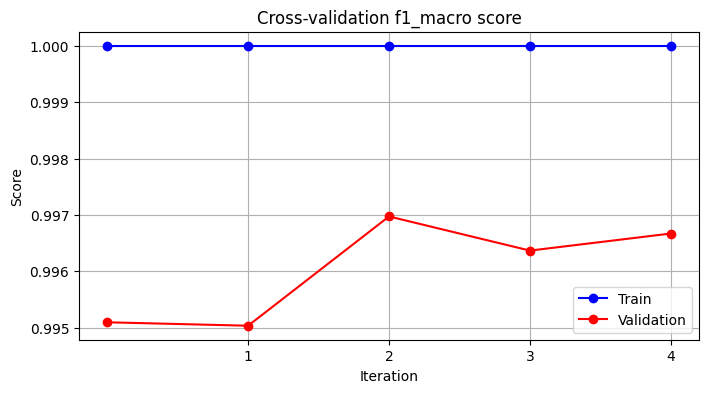

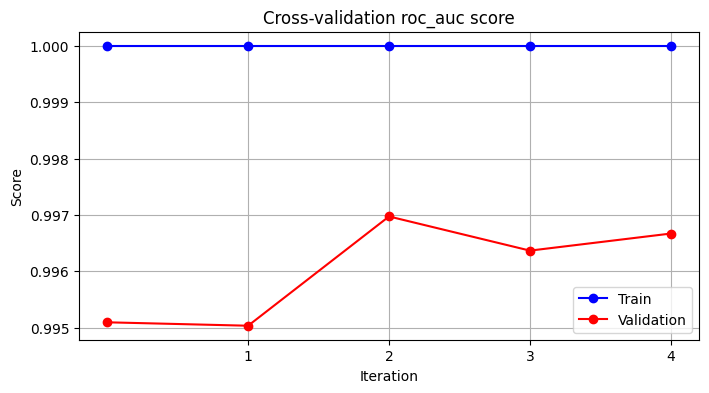

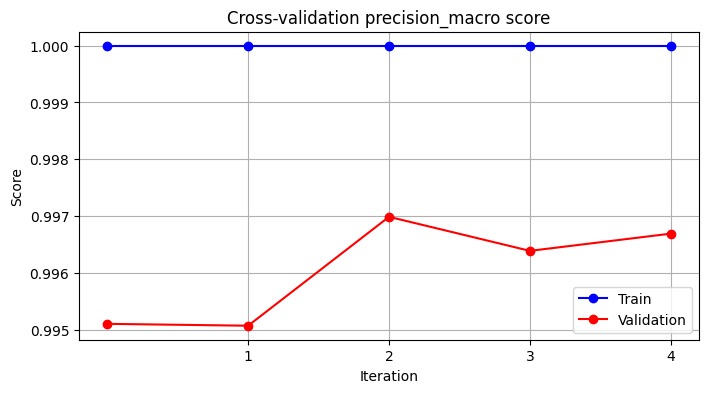

In [76]:
cv_results_ada_rf_clf = cross_validate(estimator=ada_rf_clf,
                                       X=X_train_scaled,
                                       y=y_train_balanced,
                                       scoring=parameters_rf_clf.get('cross_validation')['scores'],
                                       cv=parameters_rf_clf.get('cross_validation')['folders'],
                                       verbose=0,
                                       return_train_score=True,
                                       error_score=np.nan
                                       )

# Calculate cross-validation scores
for score in parameters_rf_clf.get('cross_validation')['scores']:
    cv_train_mean = cv_results_ada_rf_clf[f'train_{score}'].mean().round(4)
    cv_test_mean  = cv_results_ada_rf_clf[f'test_{score}'].mean().round(4)
    plot_cross_validation_score(cv_results_ada_rf_clf, score)
    print(f'>>>>>>>>> CV {score} train mean: {cv_train_mean}')
    print(f'>>>>>>>>> CV {score} test mean:  {cv_test_mean}')

In [77]:
y_pred_ada_rf_clf       = ada_rf_clf.predict(X_val_scaled)
y_pred_proba_ada_rf_clf = ada_rf_clf.predict_proba(X_val_scaled)

Accuracy:        0.99
Precision:       0.71
Recall:          0.77
F1-score:        0.74
Specificity:     0.99
AUC:             0.88

TN:              17609.00
TP:              230.00
FN:              68.00
FP:              93.00

FP rate:         0.53%
FN rate:         22.82%
False clf rate:  0.89%

No defect cost:  930.00
Predictive cost: 5750.00
Corrective cost: 34000.00
Total cost:      40680.00



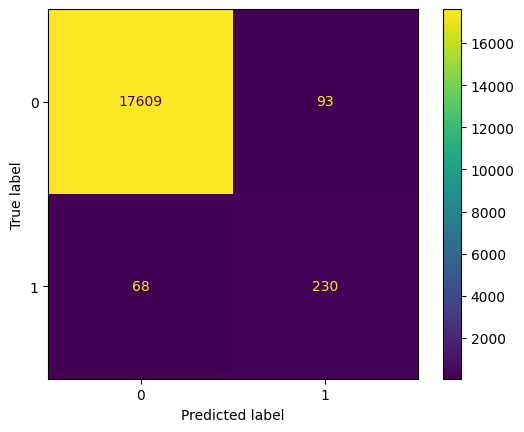

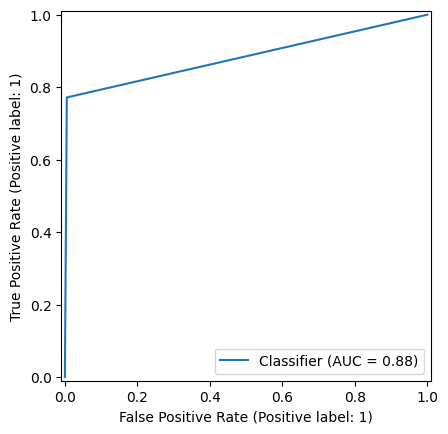

In [78]:
metrics_ada_rf_clf = calculate_metrics_standard_cutoff(y_val, y_pred_ada_rf_clf)

In [79]:
df_pred_proba_ada_rf_clf = pd.DataFrame(y_pred_proba_ada_rf_clf,
                                        columns=['proba_non_event', 'proba_event']
                                       )
df_metrics_ada_rf_clf = calculate_metrics_range_cutoff(df_pred_proba_ada_rf_clf, y_val)
plot_metrics(df_metrics_ada_rf_clf)

### Decision tree

In [80]:
from    sklearn.tree import DecisionTreeClassifier

In [81]:
ada_dt_clf = AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=RANDOM_SEED),
                                random_state=RANDOM_SEED,
                                algorithm='SAMME'
                                )
ada_dt_clf.fit(X_train_scaled, y_train_balanced)

AdaBoostClassifier(algorithm='SAMME', estimator=DecisionTreeClassifier())

#### Cross-validation scores

>>>>>>>>> CV recall train mean: 1.0
>>>>>>>>> CV recall test mean:  0.9941
>>>>>>>>> CV f1_macro train mean: 1.0
>>>>>>>>> CV f1_macro test mean:  0.9911
>>>>>>>>> CV roc_auc train mean: 1.0
>>>>>>>>> CV roc_auc test mean:  0.9911
>>>>>>>>> CV precision_macro train mean: 1.0
>>>>>>>>> CV precision_macro test mean:  0.9911


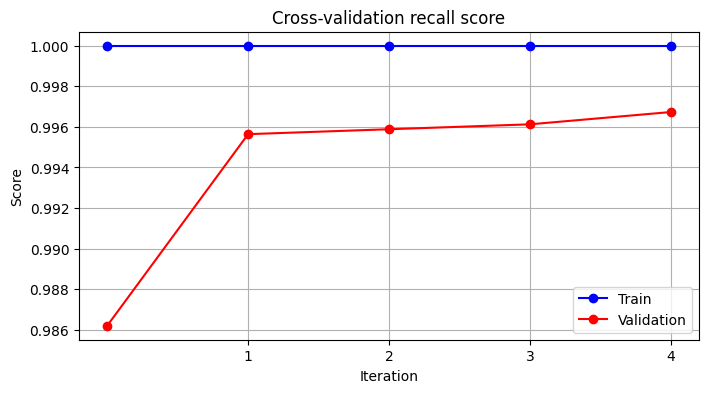

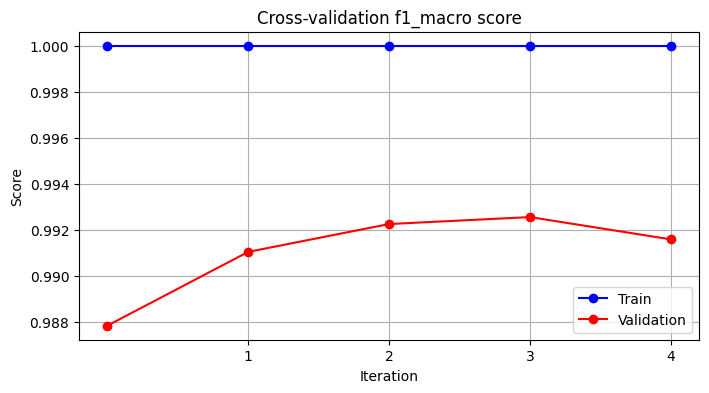

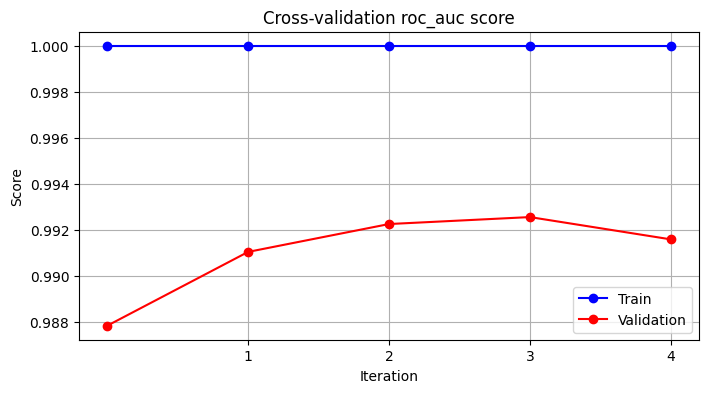

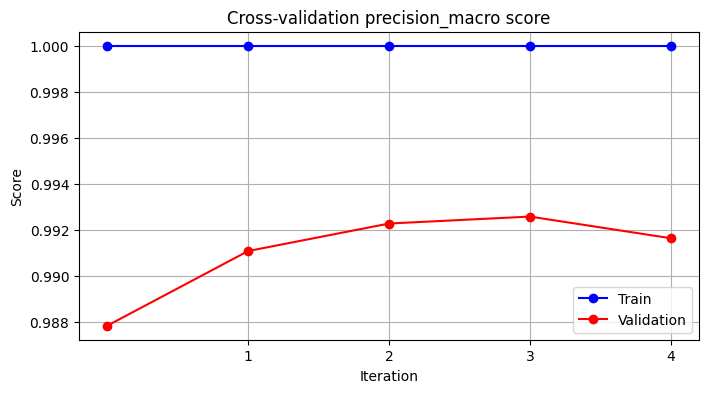

In [82]:
cv_results_ada_dt_clf = cross_validate(estimator=ada_dt_clf,
                                       X=X_train_scaled,
                                       y=y_train_balanced,
                                       scoring=parameters_rf_clf.get('cross_validation')['scores'],
                                       cv=parameters_rf_clf.get('cross_validation')['folders'],
                                       verbose=0,
                                       return_train_score=True,
                                       error_score=np.nan
                                       )

# Calculate cross-validation scores
for score in parameters_rf_clf.get('cross_validation')['scores']:
    cv_train_mean = cv_results_ada_dt_clf[f'train_{score}'].mean().round(4)
    cv_test_mean  = cv_results_ada_dt_clf[f'test_{score}'].mean().round(4)
    plot_cross_validation_score(cv_results_ada_dt_clf, score)
    print(f'>>>>>>>>> CV {score} train mean: {cv_train_mean}')
    print(f'>>>>>>>>> CV {score} test mean:  {cv_test_mean}')

In [83]:
y_pred_ada_dt_clf       = ada_dt_clf.predict(X_val_scaled)
y_pred_proba_ada_dt_clf = ada_dt_clf.predict_proba(X_val_scaled)

Accuracy:        0.99
Precision:       0.54
Recall:          0.70
F1-score:        0.61
Specificity:     0.99
AUC:             0.84

TN:              17528.00
TP:              208.00
FN:              90.00
FP:              174.00

FP rate:         0.98%
FN rate:         30.20%
False clf rate:  1.47%

No defect cost:  1740.00
Predictive cost: 5200.00
Corrective cost: 45000.00
Total cost:      51940.00



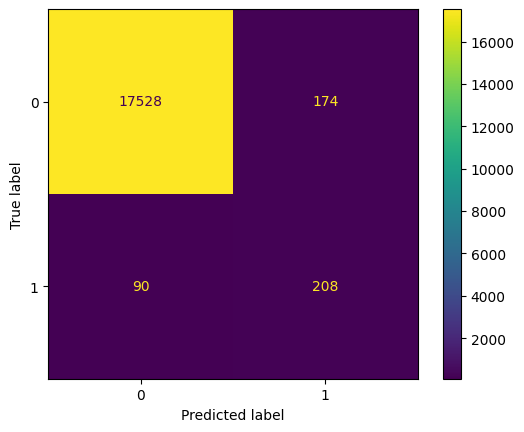

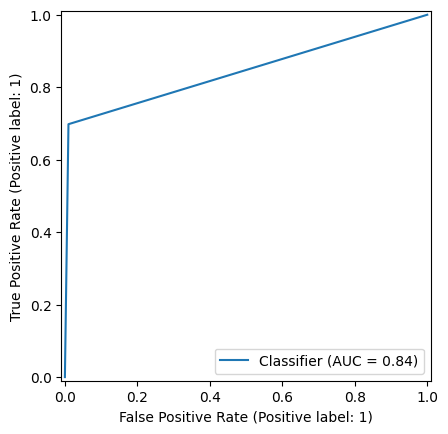

In [84]:
metrics_ada_dt_clf = calculate_metrics_standard_cutoff(y_val, y_pred_ada_dt_clf)

In [85]:
df_pred_proba_ada_dt_clf = pd.DataFrame(y_pred_proba_ada_dt_clf,
                                        columns=['proba_non_event', 'proba_event']
                                        )
df_metrics_ada_dt_clf = calculate_metrics_range_cutoff(df_pred_proba_ada_dt_clf, y_val)
plot_metrics(df_metrics_ada_dt_clf)

# Compare models

## Standard cutoff

In [101]:
columns = ['accuracy',
           'precision',
           'recall',
           'f1score',
           'auc_value',
           'specificity',
           'tn', 'fp', 'fn', 'tp',
           'false_positive_rate',
           'false_negative_rate',
           'false_classification_rate',
           'no_defect_maintenance_cost',
           'preventive_maintenance_cost',
           'corrective_maintenance_cost',
           'total_maintenance_cost']

df_metrics_standard_cutoff = pd.DataFrame(metrics_rf_clf,
                                          columns=columns
                                         )
df_metrics_standard_cutoff = pd.concat([df_metrics_standard_cutoff,
                                         pd.DataFrame(metrics_rf_clf_tuning, columns=columns)], axis=0)
df_metrics_standard_cutoff = pd.concat([df_metrics_standard_cutoff,
                                         pd.DataFrame(metrics_rf_clf_important_features, columns=columns)], axis=0)
df_metrics_standard_cutoff = pd.concat([df_metrics_standard_cutoff,
                                         pd.DataFrame(metrics_xgb_clf, columns=columns)], axis=0)
df_metrics_standard_cutoff = pd.concat([df_metrics_standard_cutoff,
                                         pd.DataFrame(metrics_xgb_clf_tuning, columns=columns)], axis=0)
df_metrics_standard_cutoff = pd.concat([df_metrics_standard_cutoff,
                                         pd.DataFrame(metrics_xgb_clf_important_features, columns=columns)], axis=0)
df_metrics_standard_cutoff = pd.concat([df_metrics_standard_cutoff,
                                         pd.DataFrame(metrics_mlp_clf, columns=columns)], axis=0)
df_metrics_standard_cutoff = pd.concat([df_metrics_standard_cutoff,
                                         pd.DataFrame(metrics_ada_rf_clf, columns=columns)], axis=0)
df_metrics_standard_cutoff = pd.concat([df_metrics_standard_cutoff,
                                         pd.DataFrame(metrics_ada_dt_clf, columns=columns)], axis=0)
df_metrics_standard_cutoff['model'] = ['rf_clf',
                                       'rf_clf_tuning',
                                       'ada_rf_clf_tuning',
                                       'xgb_clf',
                                       'xgb_clf_tuning',
                                       'xgb_clf_important_features',
                                       'mlp_clf',
                                       'ada_rf_clf',
                                       'ada_dt_clf'
                                       ]
df_metrics_standard_cutoff

,accuracy,precision,recall,f1score,auc_value,specificity,tn,fp,fn,tp,false_positive_rate,false_negative_rate,false_classification_rate,no_defect_maintenance_cost,preventive_maintenance_cost,corrective_maintenance_cost,total_maintenance_cost,model
0,0.991000,0.707317,0.778523,0.741214,0.886550,0.994577,17606,96,66,232,0.542312,22.147651,0.900000,960,5800,33000,39760,rf_clf
0,0.939556,0.210411,0.963087,0.345367,0.951123,0.939159,16625,1077,11,287,6.084058,3.691275,6.044444,10770,7175,5500,23445,rf_clf_tuning
0,0.941111,0.214393,0.959732,0.350490,0.950265,0.940798,16654,1048,12,286,5.920235,4.026846,5.888889,10480,7150,6000,23630,ada_rf_clf_tuning
0,0.992778,0.776316,0.791946,0.784053,0.894052,0.996159,17634,68,62,236,0.384137,20.805369,0.722222,680,5900,31000,37580,xgb_clf
0,0.992778,0.776316,0.791946,0.784053,0.894052,0.996159,17634,68,62,236,0.384137,20.805369,0.722222,680,5900,31000,37580,xgb_clf_tuning
0,0.990278,0.674221,0.798658,0.731183,0.896081,0.993504,17587,115,60,238,0.649644,20.134228,0.972222,1150,5950,30000,37100,xgb_clf_important_features
0,0.990000,0.702055,0.687919,0.694915,0.841502,0.995085,17615,87,93,205,0.491470,31.208054,1.000000,870,5125,46500,52495,mlp_clf
0,0.991056,0.712074,0.771812,0.740741,0.883279,0.994746,17609,93,68,230,0.525364,22.818792,0.894444,930,5750,34000,40680,ada_rf_clf
0,0.985333,0.544503,0.697987,0.611765,0.844079,0.990171,17528,174,90,208,0.982940,30.201342,1.466667,1740,5200,45000,51940,ada_dt_clf


In [102]:
lower_total_cost = df_metrics_standard_cutoff['total_maintenance_cost'].min()
select_model = df_metrics_standard_cutoff[df_metrics_standard_cutoff['total_maintenance_cost'] == lower_total_cost]
select_model

,accuracy,precision,recall,f1score,auc_value,specificity,tn,fp,fn,tp,false_positive_rate,false_negative_rate,false_classification_rate,no_defect_maintenance_cost,preventive_maintenance_cost,corrective_maintenance_cost,total_maintenance_cost,model
0,0.939556,0.210411,0.963087,0.345367,0.951123,0.939159,16625,1077,11,287,6.084058,3.691275,6.044444,10770,7175,5500,23445,rf_clf_tuning


In [103]:
for column in df_metrics_standard_cutoff.columns:
    if column != 'model':
        fig = px.bar(df_metrics_standard_cutoff,
                x='model',
                y=column,
                text_auto=True,
                text=column
                )
        fig.update_traces(texttemplate='%{text:.3f}')

        fig.update_layout(height=400,
                        width=800,
                        showlegend=True,
                        margin=dict(l=10, r=10, b=10, t=10),
                        yaxis = dict(title=column.title()),
                        xaxis = dict(title='Model')
                        )
        fig.show()

## Various cutoffs

In [104]:
df_compare_metrics = df_metrics_rf_clf.copy()
df_compare_metrics['model'] = 'rf_clf'

In [105]:
df_metrics_rf_clf_tuning['model']              = 'rf_clf_tuning'
df_metrics_rf_clf_important_features['model']  = 'rf_clf_important_features'
df_metrics_xgb_clf['model']                    = 'xgb_clf'
df_metrics_xgb_clf_tuning['model']             = 'xgb_clf_tuning'
df_metrics_xgb_clf_important_features['model'] = 'xgb_clf_important_features'
df_metrics_mlp_clf['model']                    = 'mlp_clf'
df_metrics_ada_rf_clf['model']                 = 'ada_rf_clf'
df_metrics_ada_dt_clf['model']                 = 'ada_dt_clf'

df_compare_metrics = pd.concat([df_compare_metrics, df_metrics_rf_clf_tuning], axis=0)
df_compare_metrics = pd.concat([df_compare_metrics, df_metrics_rf_clf_important_features], axis=0)
df_compare_metrics = pd.concat([df_compare_metrics, df_metrics_xgb_clf], axis=0)
df_compare_metrics = pd.concat([df_compare_metrics, df_metrics_xgb_clf_tuning], axis=0)
df_compare_metrics = pd.concat([df_compare_metrics, df_metrics_xgb_clf_important_features], axis=0)
df_compare_metrics = pd.concat([df_compare_metrics, df_metrics_mlp_clf], axis=0)
df_compare_metrics = pd.concat([df_compare_metrics, df_metrics_ada_rf_clf], axis=0)
df_compare_metrics = pd.concat([df_compare_metrics, df_metrics_ada_dt_clf], axis=0)

df_compare_metrics

,cutoff,accuracy,precision,recall,f1score,auc_value,tn,fp,fn,tp,specificity,false_positive_rate,false_negative_rate,false_classification_rate,no_defect_maintenance_cost,preventive_maintenance_cost,corrective_maintenance_cost,total_maintenance_cost,model
0,0.05,0.943056,0.221028,0.966443,0.359775,0.954552,16687,1015,10,288,0.942662,5.733815,3.355705,5.694444,10150,7200,5000,22350,rf_clf
1,0.10,0.962278,0.300105,0.959732,0.457234,0.961026,17035,667,12,286,0.962321,3.767936,4.026846,3.772222,6670,7150,6000,19820,rf_clf
2,0.15,0.971722,0.363519,0.942953,0.524743,0.957580,17210,492,17,281,0.972207,2.779347,5.704698,2.827778,4920,7025,8500,20445,rf_clf
3,0.20,0.977722,0.421613,0.929530,0.580105,0.954032,17322,380,21,277,0.978533,2.146650,7.046980,2.227778,3800,6925,10500,21225,rf_clf
4,0.25,0.982167,0.479789,0.916107,0.629758,0.949693,17406,296,25,273,0.983279,1.672127,8.389262,1.783333,2960,6825,12500,22285,rf_clf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,0.75,0.985333,0.544503,0.697987,0.611765,0.844079,17528,174,90,208,0.990171,0.982940,30.201342,1.466667,1740,5200,45000,51940,ada_dt_clf
15,0.80,0.985333,0.544503,0.697987,0.611765,0.844079,17528,174,90,208,0.990171,0.982940,30.201342,1.466667,1740,5200,45000,51940,ada_dt_clf
16,0.85,0.985333,0.544503,0.697987,0.611765,0.844079,17528,174,90,208,0.990171,0.982940,30.201342,1.466667,1740,5200,45000,51940,ada_dt_clf
17,0.90,0.983444,0.000000,0.000000,0.000000,0.500000,17702,0,298,0,1.000000,0.000000,100.000000,1.655556,0,0,149000,149000,ada_dt_clf


In [106]:
df_compare_metrics.groupby(['cutoff', 'model']).mean()

accuracy  precision    recall   f1score  \
cutoff model                                                                 
0.05   ada_dt_clf                  0.016556   0.016556  1.000000  0.032572   
       ada_rf_clf                  0.016556   0.016556  1.000000  0.032572   
       mlp_clf                     0.985389   0.544304  0.721477  0.620491   
       rf_clf                      0.943056   0.221028  0.966443  0.359775   
       rf_clf_important_features   0.782944   0.069845  0.983221  0.130425   
...                                     ...        ...       ...       ...   
0.95   rf_clf_important_features   0.979389   0.384127  0.406040  0.394780   
       rf_clf_tuning               0.978556   0.358974  0.375839  0.367213   
       xgb_clf                     0.993000   0.887387  0.661074  0.757692   
       xgb_clf_important_features  0.991833   0.868293  0.597315  0.707753   
       xgb_clf_tuning              0.993000   0.887387  0.661074  0.757692   

                                   auc_value       tn       fp     fn     tp  \
cutoff model                                                                   
0.05   ada_dt_clf                   0.500000      0.0  17702.0    0.0  298.0   
       ada_rf_clf                   0.500000      0.0  17702.0    0.0  298.0   
       mlp_clf                      0.855654  17522.0    180.0   83.0  215.0   
       rf_clf                       0.954552  16687.0   1015.0   10.0  288.0   
       rf_clf_important_features    0.881397  13800.0   3902.0    5.0  293.0   
...                                      ...      ...      ...    ...    ...   
0.95   rf_clf_important_features    0.697541  17508.0    194.0  177.0  121.0   
       rf_clf_tuning                0.682270  17502.0    200.0  186.0  112.0   
       xgb_clf                      0.829831  17677.0     25.0  101.0  197.0   
       xgb_clf_important_features   0.797895  17675.0     27.0  120.0  178.0   
       xgb_clf_tuning               0.829831  17677.0     25.0  101.0  197.0   

                                   specificity  false_positive_rate  \
cutoff model                                                          
0.05   ada_dt_clf                     0.000000           100.000000   
       ada_rf_clf                     0.000000           100.000000   
       mlp_clf                        0.989832             1.016834   
       rf_clf                         0.942662             5.733815   
       rf_clf_important_features      0.779573            22.042707   
...                                        ...                  ...   
0.95   rf_clf_important_features      0.989041             1.095921   
       rf_clf_tuning                  0.988702             1.129816   
       xgb_clf                        0.998588             0.141227   
       xgb_clf_important_features     0.998475             0.152525   
       xgb_clf_tuning                 0.998588             0.141227   

                                   false_negative_rate  \
cutoff model                                             
0.05   ada_dt_clf                             0.000000   
       ada_rf_clf                             0.000000   
       mlp_clf                               27.852349   
       rf_clf                                 3.355705   
       rf_clf_important_features              1.677852   
...                                                ...   
0.95   rf_clf_important_features             59.395973   
       rf_clf_tuning                         62.416107   
       xgb_clf                               33.892617   
       xgb_clf_important_features            40.268456   
       xgb_clf_tuning                        33.892617   

                                   false_classification_rate  \
cutoff model                                                   
0.05   ada_dt_clf                                  98.344444   
       ada_rf_clf                                  98.344444   
       mlp_clf                              

In [107]:
min_total_cost = df_compare_metrics['total_maintenance_cost'].min()
df_compare_metrics[df_compare_metrics['total_maintenance_cost'] == min_total_cost]

,cutoff,accuracy,precision,recall,f1score,auc_value,tn,fp,fn,tp,specificity,false_positive_rate,false_negative_rate,false_classification_rate,no_defect_maintenance_cost,preventive_maintenance_cost,corrective_maintenance_cost,total_maintenance_cost,model
1,0.1,0.962278,0.300105,0.959732,0.457234,0.961026,17035,667,12,286,0.962321,3.767936,4.026846,3.772222,6670,7150,6000,19820,rf_clf


In [108]:
df_compare_metrics[df_compare_metrics['cutoff'] == 0.5]

,cutoff,accuracy,precision,recall,f1score,auc_value,tn,fp,fn,tp,specificity,false_positive_rate,false_negative_rate,false_classification_rate,no_defect_maintenance_cost,preventive_maintenance_cost,corrective_maintenance_cost,total_maintenance_cost,model
9,0.5,0.991000,0.707317,0.778523,0.741214,0.886550,17606,96,66,232,0.994577,0.542312,22.147651,0.900000,960,5800,33000,39760,rf_clf
9,0.5,0.939556,0.210411,0.963087,0.345367,0.951123,16625,1077,11,287,0.939159,6.084058,3.691275,6.044444,10770,7175,5500,23445,rf_clf_tuning
9,0.5,0.941111,0.214393,0.959732,0.350490,0.950265,16654,1048,12,286,0.940798,5.920235,4.026846,5.888889,10480,7150,6000,23630,rf_clf_important_features
9,0.5,0.992778,0.776316,0.791946,0.784053,0.894052,17634,68,62,236,0.996159,0.384137,20.805369,0.722222,680,5900,31000,37580,xgb_clf
9,0.5,0.992778,0.776316,0.791946,0.784053,0.894052,17634,68,62,236,0.996159,0.384137,20.805369,0.722222,680,5900,31000,37580,xgb_clf_tuning
9,0.5,0.990278,0.674221,0.798658,0.731183,0.896081,17587,115,60,238,0.993504,0.649644,20.134228,0.972222,1150,5950,30000,37100,xgb_clf_important_features
9,0.5,0.990000,0.702055,0.687919,0.694915,0.841502,17615,87,93,205,0.995085,0.491470,31.208054,1.000000,870,5125,46500,52495,mlp_clf
9,0.5,0.991056,0.712074,0.771812,0.740741,0.883279,17609,93,68,230,0.994746,0.525364,22.818792,0.894444,930,5750,34000,40680,ada_rf_clf
9,0.5,0.985333,0.544503,0.697987,0.611765,0.844079,17528,174,90,208,0.990171,0.982940,30.201342,1.466667,1740,5200,45000,51940,ada_dt_clf


# Test

In [109]:
df_test = pd.read_csv('data\\original\\air_system_present_year.csv',
                      encoding='utf-8',
                      na_values=['na']
                      )

In [110]:
df_test_target = df_test[['class']]
# Change class to int dummies
map_class = {'neg': 0, 'pos': 1}
df_test_target.loc[:, 'class'] = df_test_target['class'].map(map_class)
y_test = df_test_target['class'].astype(int)
y_test

0        0
1        0
2        0
3        0
4        0
        ..
15995    0
15996    0
15997    0
15998    0
15999    0
Name: class, Length: 16000, dtype: int64

In [111]:
# Calculate events proportion
total_test     = df_test_target.shape[0]
non_event_test = df_test_target[df_test_target['class'] == 0].shape[0]
event_test     = df_test_target[df_test_target['class'] == 1].shape[0]

non_event_test_percent = round(non_event_test / total_test * 100, 2)
event_test_percent     = round(event_test / total_test * 100, 2)

non_event_test_percent, event_test_percent

(97.66, 2.34)

In [112]:
df_test_features = df_test[X_train_balanced.columns]
df_test_features = df_test_features.astype(float)
df_test_features

,bl_000,bk_000,cg_000,ch_000,cf_000,co_000,ad_000,cx_000,cy_000,cz_000,...,aq_000,ao_000,bj_000,bi_000,by_000,ck_000,ci_000,cj_000,bt_000,aa_000
0,NaN,NaN,6.0,0.0,0.0,8.0,12.0,1276.0,0.0,0.0,...,470.0,9480.0,3458.0,107662.0,54.0,5851.20,5913.60,0.00,59.53,60.0
1,NaN,NaN,4.0,0.0,2.0,14.0,40.0,1466.0,0.0,0.0,...,1270.0,18166.0,3134.0,20520.0,68.0,7768.32,7224.96,0.00,81.89,82.0
2,194360.0,336240.0,104.0,0.0,0.0,52.0,112.0,1911060.0,0.0,284.0,...,286536.0,3291610.0,265492.0,692800.0,22706.0,374649.60,3594885.12,0.00,66002.89,66002.0
3,208420.0,176000.0,144.0,0.0,0.0,1278.0,936.0,64066.0,0.0,674.0,...,423374.0,3053176.0,316130.0,331744.0,29967.0,599624.64,3387773.76,38633.28,59816.46,59816.0
4,NaN,NaN,8.0,0.0,0.0,2.0,140.0,57312.0,44.0,4.0,...,5092.0,89920.0,4966.0,7932.0,364.0,9556.80,94319.04,0.00,1813.74,1814.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,228440.0,239020.0,138.0,0.0,2.0,42.0,892.0,1124612.0,0.0,64940.0,...,669608.0,3779700.0,493980.0,475928.0,42112.0,847887.36,4457943.36,0.00,81851.77,81852.0
15996,NaN,NaN,10.0,0.0,2.0,0.0,46.0,220.0,0.0,52.0,...,1338.0,12242.0,4264.0,2932.0,38.0,8124.48,3330.24,0.00,18.41,18.0
15997,277120.0,225360.0,76.0,0.0,2.0,378.0,1518.0,55486.0,0.0,3468.0,...,578006.0,3828492.0,419172.0,817038.0,38013.0,417673.92,4694372.16,0.00,79635.97,79636.0
15998,NaN,NaN,8.0,0.0,0.0,0.0,32.0,2880.0,0.0,0.0,...,6160.0,13504.0,14332.0,46216.0,76.0,20952.00,10367.04,0.00,109.52,110.0


In [113]:
df_test_features.isna().sum().sort_values(ascending=False)

bl_000    7226
bk_000    6094
cg_000    3981
ch_000    3981
cf_000    3981
          ... 
ck_000      86
ci_000      86
cj_000      86
bt_000      28
aa_000       0
Length: 161, dtype: int64

## Input data on NaN

In [114]:
X_test_filled_nan = imputer.transform(df_test_features)
X_test_filled_nan = pd.DataFrame(X_test_filled_nan, columns=df_test_features.columns)
X_test_filled_nan.isna().sum().sum()

np.int64(0)

In [115]:
X_test_filled_nan.head()

,bl_000,bk_000,cg_000,ch_000,cf_000,co_000,ad_000,cx_000,cy_000,cz_000,...,aq_000,ao_000,bj_000,bi_000,by_000,ck_000,ci_000,cj_000,bt_000,aa_000
0,223120.0,210550.0,6.0,0.0,0.0,8.0,12.0,1276.0,0.0,0.0,...,470.0,9480.0,3458.0,107662.0,54.0,5851.20,5913.60,0.00,59.53,60.0
1,223120.0,210550.0,4.0,0.0,2.0,14.0,40.0,1466.0,0.0,0.0,...,1270.0,18166.0,3134.0,20520.0,68.0,7768.32,7224.96,0.00,81.89,82.0
2,194360.0,336240.0,104.0,0.0,0.0,52.0,112.0,1911060.0,0.0,284.0,...,286536.0,3291610.0,265492.0,692800.0,22706.0,374649.60,3594885.12,0.00,66002.89,66002.0
3,208420.0,176000.0,144.0,0.0,0.0,1278.0,936.0,64066.0,0.0,674.0,...,423374.0,3053176.0,316130.0,331744.0,29967.0,599624.64,3387773.76,38633.28,59816.46,59816.0
4,223120.0,210550.0,8.0,0.0,0.0,2.0,140.0,57312.0,44.0,4.0,...,5092.0,89920.0,4966.0,7932.0,364.0,9556.80,94319.04,0.00,1813.74,1814.0


# Predict

In [125]:
select_model

,accuracy,precision,recall,f1score,auc_value,specificity,tn,fp,fn,tp,false_positive_rate,false_negative_rate,false_classification_rate,no_defect_maintenance_cost,preventive_maintenance_cost,corrective_maintenance_cost,total_maintenance_cost,model
0,0.939556,0.210411,0.963087,0.345367,0.951123,0.939159,16625,1077,11,287,6.084058,3.691275,6.044444,10770,7175,5500,23445,rf_clf_tuning


In [135]:
rf_clf_tuning.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(max_depth=np.int64(8), min_samples_leaf=np.int64(2),
                       min_samples_split=np.float64(0.30000000000000004),
                       n_estimators=np.int64(15))

In [136]:
y_pred_test = rf_clf_tuning.predict(X_test_filled_nan)
y_pred_proba_test = rf_clf_tuning.predict_proba(X_test_filled_nan)

Accuracy:        0.94
Precision:       0.27
Recall:          0.98
F1-score:        0.42
Specificity:     0.94
AUC:             0.96

TN:              14621.00
TP:              367.00
FN:              8.00
FP:              1004.00

FP rate:         6.43%
FN rate:         2.13%
False clf rate:  6.33%

No defect cost:  10040.00
Predictive cost: 9175.00
Corrective cost: 4000.00
Total cost:      23215.00



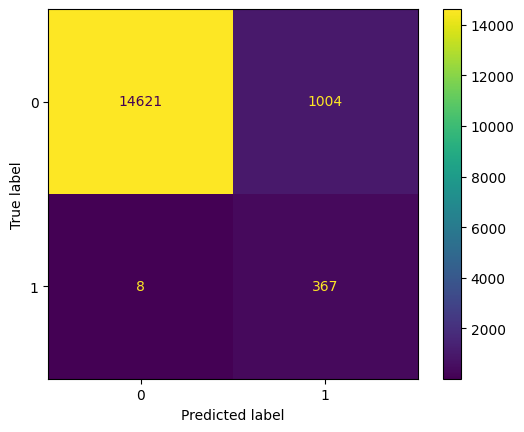

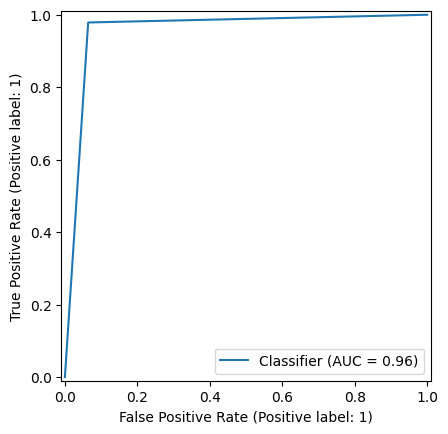

In [137]:
metrics_test = calculate_metrics_standard_cutoff(y_test, y_pred_test)

In [138]:
df_pred_proba_rf_clf_tuning = pd.DataFrame(y_pred_proba_rf_clf_tuning,
                                           columns=['proba_non_event', 'proba_event']
                                           )
df_metrics_rf_clf_tuning = calculate_metrics_range_cutoff(df_pred_proba_rf_clf_tuning, y_val)
df_metrics_rf_clf_tuning
plot_metrics(df_metrics_rf_clf_tuning)

# Historical data

In [139]:
min_test_cost = df_metrics_rf_clf_tuning['total_maintenance_cost'].min()
min_test_cost

np.int64(23445)

In [140]:
historical_cost = pd.DataFrame(data=[[24000], [26000], [28999], [32000], [37000], [min_test_cost]],
                               index=[2016, 2017, 2018, 2019, 2020, 2021],
                               columns=['cost']
                               )
historical_cost['pct_change'] = historical_cost['cost'].pct_change(periods=1) * 100
historical_cost['amount_change'] = historical_cost['cost'].diff()

historical_cost

,cost,pct_change,amount_change
2016,24000,NaN,NaN
2017,26000,8.333333,2000.0
2018,28999,11.534615,2999.0
2019,32000,10.348633,3001.0
2020,37000,15.625000,5000.0
2021,23445,-36.635135,-13555.0


In [141]:
total_historical_cost = historical_cost.sum().values[0]
total_historical_cost

np.float64(171444.0)

In [142]:
fig = make_subplots()

fig.add_trace(go.Bar(
    x=historical_cost.index[:-1],
    y=historical_cost['cost'][:-1],
    name='Historical cost',
    marker=dict(color='red'),
    text=historical_cost['cost'][:-1])
    )

fig.add_trace(go.Bar(
    x=historical_cost.index[-1:],
    y=historical_cost['cost'][-1:],
    name='Estimated cost',
    marker=dict(color='Blue'),
    text=historical_cost['cost'][-1:])
    )

fig.update_layout(height=400,
                  width=800,
                  showlegend=True,
                  margin=dict(l=10, r=10, b=10, t=35, pad=0),
                  xaxis=dict(title=None),
                  yaxis=dict(title='US$', titlefont=dict(size=14)),
                  title=f"US$ {abs(historical_cost['amount_change'][-1:].values[0]):.2f} saved with machine learning"
                  )
fig.show()

In [143]:
fig = make_subplots()

fig.add_trace(go.Bar(
    x=historical_cost.index[:-1],
    y=historical_cost['pct_change'][:-1],
    name='Historical cost',
    marker=dict(color='red'),
    text=historical_cost['pct_change'][:-1].round(2))
    )

fig.add_trace(go.Bar(
    x=historical_cost.index[-1:],
    y=historical_cost['pct_change'][-1:],
    name='Estimated cost',
    marker=dict(color='blue'),
    text=historical_cost['pct_change'][-1:].round(2))
    )

fig.update_traces(texttemplate='%{text:.2f}%')

fig.update_layout(height=400,
                  width=800,
                  showlegend=True,
                  margin=dict(l=10, r=10, b=10, t=35, pad=0),
                  xaxis=dict(title=None),
                  yaxis=dict(title='%', titlefont=dict(size=14)),
                  title='Percentage cost variation through years'
                  )
fig.show()